# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Содержание
1. [Изучение общей информации](#header_1)
2. [Предобработка данных](#header_2)

    - [Общая инфорамация](#header_2_1)
    - [Обработка пропусков](#header_2_2)
    - [Обработка пропусков: выводы](#header_2_3)
    - [Замена типов данных](#header_2_4)
    - [Замена типов данных: выводы](#header_2_5)
    - [Обработка дубликатов](#header_2_6)
    - [Обработка дубликатов: выводы](#header_2_7)
    - [Лемматизация](#header_2_8)
    - [Лемматизация: выводы](#header_2_9)
    - [Категоризация данных](#header_2_10)
    - [Категоризация данных: выводы](#header_2_11)
    
    
3. [Анализ данных](#header_3)

    - [Зависимость между наличием детей и возвратом кредита в срок](#header_3_1)
    - [Зависимость между семейным положением и возвратом кредита в срок](#header_3_2)
    - [Зависимость между уровнем дохода и возвратом кредита в срок](#header_3_3)
    - [Влияние цели кредита на возврат в срок](#header_3_4)
    
    
4. [Общий вывод](#header_4)


## Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [468]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [469]:
#проверяем написание названий полей
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [470]:
#при вывде на печать часть полей не отображается — их слишком много
#для того, чтобы увидеть весь набор данных, настроим пандас
pd.set_option("display.max_rows", 0, "display.max_columns", 22)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [471]:
#описательный характеристики для полей
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [472]:
#проверяем, что лежит в текстовом поле 
#строк много, снова меняем нстройки вывода
pd.set_option("display.max_rows", None, "display.max_columns", None)
data.pivot_table(index = 'locality_name', values = 'total_images', aggfunc = 'count').sort_values('locality_name')

,total_images
locality_name,
Бокситогорск,16
Волосово,36
Волхов,111
Всеволожск,398
Выборг,237
Высоцк,4
Гатчина,307
Зеленогорск,24
Ивангород,28


In [473]:
#возвращаем настройки вывода обратно
pd.set_option("display.max_rows", 0, "display.max_columns", 0)

## Вывод

### Общее
В данных есть информация о 23699 объектах недвижимости. 
Можно переименовать поле cityCenters_nearest — city_centers_nearest. С наименованием остальных полей все хорошо. 

### Пропуски
Почти по всем столбцам есть NaN значения. Их нужно оценить и принять решение по их обработке:

- ceiling_height         
- floors_total            
- living_area             
- is_apartment           
- kitchen_area           
- balcony               
- locality_name          
- airports_nearest        
- cityCenters_nearest     
- parks_around3000        
- parks_nearest           
- ponds_around3000        
- ponds_nearest           
- days_exposition         

### Нетипичные и странные значения 
1. is_apartment: тип object. По смыслу больше подходит булевое значение.
2. выбивающиеся значения: 
    - 0 комнат; 
    - маловероятно высота потолка. минимальное значение 1 метр, максимальное значение 100 метров;
    - вызывают подозрения максимальные значения total_area,	rooms, floors_total, living_area; но это вполне могут быть и реальные значения	
    
### Тип данных
Заменить тип на целочисленный для полей, так как эти параметры *не могут* содержать дробные значения:

- floors_total
- balcony
- parks_around3000
- ponds_around3000
- days_exposition


>**_<span style="color:green">Здесь всё структурировано и по делу, класс. </span>_**
>


## Шаг 2. Предобработка данных

In [474]:
#переименовываем поле 'cityCenters_nearest'
data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}, inplace = True)
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

## Пропущенные значения

Вдруг часть данных, которых нет, была загружена из одного источника и для таких строк все эти поля — NaN? Тогда можно будет удалить эти строки и не переживать.

In [475]:
data.loc[(data['ceiling_height'].isna()) &
         (data['floors_total'].isna()) &
         (data['living_area'].isna()) &
         (data['is_apartment'].isna()) &
         (data['kitchen_area'].isna()) &
         (data['balcony'].isna()) &
         (data['locality_name'].isna()) &
         (data['airports_nearest'].isna()) &
         (data['city_centers_nearest'].isna()) &
         (data['parks_around3000'].isna()) &
         (data['parks_nearest'].isna()) &
         (data['ponds_around3000'].isna()) &
         (data['ponds_nearest'].isna()) &
         (data['days_exposition'].isna())
        ]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Увы :( Будем обрабатвать каждый параметр отдельно. 

Посмотрим, какой процент данных потерян для каждого параметра. Будем считать, что если потеряно **меньше 5%**, то строки можно удалить. 

In [476]:
df_nan_values = pd.DataFrame(
    (['ceiling_height', 'Высота потолка'], 
     ['floors_total', 'Количество этажей'],
     ['living_area', 'Жилая площадь'],
     ['is_apartment', 'Апартаметы'], 
     ['kitchen_area', 'Площадь кухни'],
     ['balcony', 'Количество балконов'],
     ['locality_name', 'Название населённого пункта'],
     ['airports_nearest', 'Ближайший аэропорт'], 
     ['city_centers_nearest', 'Расстояние до центра'], 
     ['parks_around3000', 'Парк в 3000м'], 
     ['parks_nearest', 'Ближайший парк'], 
     ['ponds_around3000', 'Водоем в 3000м'],
     ['ponds_nearest', 'Ближайший водоем'],
     ['days_exposition', 'Длительность размещения']),
     columns=['name_en', 'name_ru']
)

for element in range(0, len(df_nan_values)):
    print(df_nan_values['name_ru'][element])
    print('Количество пропусков:', data[df_nan_values['name_en'][element]].isna().sum())
    print('{:.2%}'.format(data[df_nan_values['name_en'][element]].isna().sum()/data['total_images'].count()))
    print('------')

Высота потолка
Количество пропусков: 9195
38.80%
------
Количество этажей
Количество пропусков: 86
0.36%
------
Жилая площадь
Количество пропусков: 1903
8.03%
------
Апартаметы
Количество пропусков: 20924
88.29%
------
Площадь кухни
Количество пропусков: 2278
9.61%
------
Количество балконов
Количество пропусков: 11519
48.61%
------
Название населённого пункта
Количество пропусков: 49
0.21%
------
Ближайший аэропорт
Количество пропусков: 5542
23.38%
------
Расстояние до центра
Количество пропусков: 5519
23.29%
------
Парк в 3000м
Количество пропусков: 5518
23.28%
------
Ближайший парк
Количество пропусков: 15620
65.91%
------
Водоем в 3000м
Количество пропусков: 5518
23.28%
------
Ближайший водоем
Количество пропусков: 14589
61.56%
------
Длительность размещения
Количество пропусков: 3181
13.42%
------



>**_<span style="color:green">Крутое решение с циклом, но не стоит забывать и о более простых способах (см. пример моего кода ниже). </span>_**
>


In [477]:
data.isnull().sum() / len(data) * 100

total_images             0.000000
last_price               0.000000
total_area               0.000000
first_day_exposition     0.000000
rooms                    0.000000
ceiling_height          38.799105
floors_total             0.362885
living_area              8.029875
floor                    0.000000
is_apartment            88.290645
studio                   0.000000
open_plan                0.000000
kitchen_area             9.612220
balcony                 48.605426
locality_name            0.206760
airports_nearest        23.384953
city_centers_nearest    23.287902
parks_around3000        23.283683
parks_nearest           65.909954
ponds_around3000        23.283683
ponds_nearest           61.559559
days_exposition         13.422507
dtype: float64

Нашлись такие! "Количество этажей" и "Название населённого пункта" — строки, где эти поля NaN'ы, можно без сожалений дропнуть.

In [478]:
data.dropna(subset = ['floors_total', 'locality_name'], inplace = True)

### Замена на средние значения

В ряде параметров уместно заменить значения на медиану или среднее

**Высота потолка**: в датасете нет информации, по которой однозначно можно определить высоту потолка (например, тип дома). Поэтому будем заполнять стандартными значениями.

In [479]:
#print('Средняя высота потолка: {:.2f}'.format(data['ceiling_height'].mean()))
#print('Медианная высота потолка: {:.2f}'.format(data['ceiling_height'].median()))
#print('99% квантиль: {:.2f}'.format(data['ceiling_height'].quantile(.99)))

Получается, что меньше 1% значений превышают 3.82 метра. Могут ли они ухудшить оценку среднего?

In [480]:
#data.loc[(data['ceiling_height'] > 3.82) & (data['ceiling_height'] <= 100)]['ceiling_height'].value_counts().sort_index()

Есть вполне адекватные велечины, а есть потолки больше 10 метров. Везет кому-то :) А мы будем использовать для замены медиану, чтобы эти счастливчики на нас не повлияли.

In [481]:
#замена пропусков медианным значением
#ceiling_height_median = data['ceiling_height'].median()
#data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = ceiling_height_median

#проверка
#print('Количесвто пропусков после замены:', data['ceiling_height'].isna().sum())


> **<span style="color:orange">Такое заполнение пропуска может скорее помешать.</span>**
>
> **<span style="color:orange">*Пример*: в дальнейшем анализе мы можем захотеть посчитать зависимость цены от высоты потолка. При таком заполнении пропуска, мы добавим к реальным данным (где есть и заполенная высота потолка, и цена) наши синтетические (медианы значений высоты потолка и реальные цены этих квартир). При чем таких значений будет 40%.</span>** 
>
> **<span style="color:orange">*Что произойдет*: мы можем сделать неправильные выводы из анализа зависимости цены от потолка.</span>** 
>
> **<span style="color:orange">*Как правильно поступить в случае этого столбца*: забить на пропуск : ) Подавляющее большинство методов анализа, которые вы сейчас проходите, будут корректно обрабатывать датафрейм, в котоором в некоторых строках есть NaN в одном подмножестве столбцов, в некоторых – в другом. Это касается в том числе методов, используемых в этой домашке: точки на графиках для NaN-значений просто не построятся, корелляция для этих строк не посчитается, и часто это лучше, чем добавление множества синтетических точек.</span>** 
>
> **<span style="color:orange">*Когда так не надо делать?* Не стоит забивать на пропуск, если мы можем с большой уверенностью предположить возможную причину пропуска и полезное значение на замену. Такие примеры есть в этой домашке (например, балкон). Также в некоторые методы, в том числе некоторые методы машинного обучения, категорически не умеют работать с пропусками, но таких методов в вашем арсенале пока нет, можно не беспокоиться.</span>** 
>
> **_<span style="color:orange">В общем случае, если этого не требуют используемые методы, или если это явно не указано в задаче, то можно не ставить целью получить данные польностью без NaN.</span>_**
>

**Жилая площадь, площадь кухни**: жилье бывает разное, может кто-то и резиденцию продает в 900 м2. В датасете нет информации, по которой однозначно можно определить площадь (например, тип дома). Площадь кухни и жилая площадь очень сильно коррелируют как между собой, так и с общей площадью. Поэтому посчитаем средние соостношения жилой площади к общей, площади кухни к общей и при помощи этого коэффициента заполним пропуски. 

In [482]:
#соотношение жилой и общей площади, 
data['living_of_total_area'] = data['living_area']/data['total_area']

#отношение площади кухни к общей
data['kitchen_of_total_area'] = data['kitchen_area']/data['total_area']

data.loc[data['living_area'].isna(), 'living_area'] = data['total_area'] * data['living_of_total_area'].mean()
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data['total_area'] * data['kitchen_of_total_area'].mean()

#дропнула столбцы, так как в них не полные данные, а дальше в проекте все равно надо их считать
data.drop('living_of_total_area', axis = 1, inplace = True)
data.drop('kitchen_of_total_area', axis = 1, inplace = True)

#проверка
print()
print('Количесвто пропусков после замены:')
print('- жилая площадь:', data['living_area'].isna().sum())
print('- площадь кухни:', data['kitchen_area'].isna().sum())


Количесвто пропусков после замены:
- жилая площадь: 0
- площадь кухни: 0



> **<span style="color:orange">Кажется, что такой подход тоже не совсем достоверно отражает действительность. Всё-таки площадь кухни и жилая площадь очень сильно коррелируют как и между собой, так и с общей площадью. Поэтому я бы посчитал средние соостношения жилой площади к общей, и площади кухни к общей и при помощь этого коэффициента заполнил пропуски (умножая общую площадь на полученные коэффициенты). </span>**
>
> Спасибо! Такое классное решение. Поправила 


**Время размещения**: в данных нет информации о дате снятия объявления с публикации. При этом для всех объектов заполнена информация о "цене на момент снятия с публикации". То есть все объекты уже проданы и рассчитывть количество дней размещения просто вычитая дату размещения из сегодняшней даты неверно. Потэому берем медиану. Среднее может оказаться смещенным за счет коротких (1 день) и длинных (1520 дней) периодов размещения. 

In [483]:
#data.loc[data['days_exposition'].isna(), 'days_exposition'] = data['days_exposition'].median()

#проверка
#print('Количесвто пропусков после замены:', data['days_exposition'].isna().sum())


> **<span style="color:orange">Данные пропуски я бы тоже оставил без внимания, предположив, что если в этой колонке пропуск, то наше объявление еще было активно на момент подготовки выгрузки. </span>**
>
> Можно ли считать, что максимальная дата в столбце "дата публикации" — ближайшая дата выгрузки (назовем max_dt)? Тогда количество дней публикации = max_dt - first_day_exposition? Четно, не моя идея — преподавателя :) но очень хотелось найти решение для замены 


In [484]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
max_dt = data['first_day_exposition'].max()
data.loc[data['days_exposition'].isna(), 'days_exposition'] = (max_dt - data.loc[data['days_exposition'].isna(), 'first_day_exposition']).dt.days

#проверка
print('Количесвто пропусков после замены:', data['days_exposition'].isna().sum())

Количесвто пропусков после замены: 0


### Замена на логические значения

**Апартаменты**: примем за истину, что если в поле NaN — то имели в виду "нет", то есть False. Это подходит по смыслу — апартаменты явление не частое. 

In [485]:
print(data['is_apartment'].value_counts())

False    2710
True       50
Name: is_apartment, dtype: int64


In [486]:
data.loc[data['is_apartment'].isna(), 'is_apartment'] = False

#проверка
print('Количесвто пропусков после замены:', data['is_apartment'].isna().sum())

Количесвто пропусков после замены: 0


**Балконы**: если не указано количество балконов, то их может и не быть. 

Это подходит для первых этажей, но для 26 этажа уже сомнительно. При этом максимальное колчество пропусков приходится именно на первые этажи.

Для анализа информация о балконах нам не супер важна, так что заполним нулями — как будто нет балкона (а если есть — будет приятный сюрприз  для покупателя). 

In [487]:
#смотрим распределение пропусков по этажам 
print(data.loc[data['balcony'].isna()].groupby('floor')['total_images'].count())

floor
1     1926
2     1773
3     1514
4     1350
5     1237
6      588
7      506
8      467
9      410
10     280
11     214
12     204
      ... 
18      74
19      55
20      36
21      49
22      50
23      39
24      23
25      21
26       6
27       5
30       1
31       1
Name: total_images, Length: 29, dtype: int64


In [488]:
#замена
data.loc[data['balcony'].isna(), 'balcony'] = 0

#проверка
print('Количесвто пропусков после замены:', data['balcony'].isna().sum())

Количесвто пропусков после замены: 0


### Оставляем без изменений?

In [489]:
print(data.query('airports_nearest.isnull()')['total_images'].count())
print(data.query('city_centers_nearest.isnull()')['total_images'].count())
print(data.query('parks_around3000.isnull()')['total_images'].count())
print(data.query('ponds_around3000.isnull()')['total_images'].count())
print(data.query('parks_nearest.isnull()')['total_images'].count())
print(data.query('ponds_nearest.isnull()')['total_images'].count())

5524
5501
5500
5500
15535
14529


Плюс-минус одинаковое количество пропусков по гео-данным говорит о том, что скорее всего это ошибка загрузки. С расстоянием до парков/прудов нужно смотреть отдельно.

#### Расстояние до центра, аэропорта 

Хотя это важные значения для анализа, получить достоверные данные по этим величинам мы не можем. Даже если усреднить значения по этим полям в рамках города, это не даст нам понимания о том, насколько на самом деле далеко объект. Такая замена может ухудшить результат исследования.
Для достоверного усреднения необходима большая детализация по местонахождению объекта: не населенный пункт, а район населенного пункта. 

*Поэтому пропуски я бы оставила как есть. Но для тренировки заполняем* 


> **<span style="color:green">Здесь все отлично. Полностью согласен с тобой, что подобные замены скорее нам навредят и нужно решать этот вопрос с заказчиком/поставщиком данных. </span>**
>


In [490]:
#приведение к верхнему регистру
data['locality_name'] = data['locality_name'].str.upper()

#замена "ё" на "е"
data.loc[(data['locality_name'].str.contains('Ë', regex = False) == True), 'locality_name'] = data['locality_name'].replace(to_replace='[Ë]', value='Е', regex=True)

#проверка
#data.loc[(data['locality_name'].str.contains('ё', regex = False) == True)]['locality_name'].count() 


In [491]:
df1 = data.loc[data['city_centers_nearest'].notna()].pivot_table(index = 'locality_name', values = 'city_centers_nearest', aggfunc = 'median')
df1

,city_centers_nearest
locality_name,
ЗЕЛЕНОГОРСК,53381.0
КОЛПИНО,32018.0
КРАСНОЕ СЕЛО,29148.5
КРОНШТАДТ,49575.0
ЛОМОНОСОВ,51677.0
ПАВЛОВСК,32683.0
ПЕТЕРГОФ,33771.0
ПОСЁЛОК АЛЕКСАНДРОВСКАЯ,27468.0
ПОСЁЛОК БЕЛООСТРОВ,38868.0


In [492]:
data = data.join(df1, on = 'locality_name', rsuffix='_new')

In [493]:
data.loc[data['city_centers_nearest'].isna(), 'city_centers_nearest'] = data['city_centers_nearest_new']
data.drop('city_centers_nearest_new', axis = 1, inplace = True)

print('Удалось заполнить пропусков:', 5501 - data.loc[data['city_centers_nearest'].isna()]['total_images'].count())

Удалось заполнить пропусков: 69


Для некоторых населенных пунктов (26 штук) удалось заполнить существующие пропуски по расстоянию до центра медианой по населенному пункту. Для остальных пропуски заполним средним по всему датасету, предварительно определив тип поселения. Кажется, что расстояние до центра в разных типах населенных пунктов должно отличаться.

In [494]:
from pymystem3 import Mystem
m = Mystem()
lemmas = m.lemmatize(' '.join(data['locality_name']))
from collections import Counter
print(Counter(lemmas))

Counter({' ': 28768, 'санкт-петербург': 15651, 'поселок': 2650, 'деревня': 944, 'муриный': 586, 'городской': 548, 'шушар': 439, 'кудрово': 414, 'всеволожск': 398, 'пушкин': 369, 'тип': 362, 'колпино': 338, 'парголовый': 327, 'гатчина': 307, 'выборг': 237, 'село': 208, 'петергоф': 201, 'красный': 188, 'новый': 186, 'сестрорецк': 183, 'девяткино': 143, 'сертолово': 142, 'ломоносов': 133, 'кириши': 116, 'бугор': 113, 'сланцы': 112, 'волхов': 111, 'сосновый': 105, 'кингисепп': 104, 'тосно': 104, 'бор': 101, 'кронштадт': 96, 'никольское': 94, '-': 91, 'коммунар': 90, 'кировск': 84, 'отрадный': 79, 'старый': 75, '1': 68, 'янино': 66, 'металлострой': 66, 'приозерск': 66, 'луг': 61, 'шлиссельбург': 57, 'кудровый': 56, 'имя': 53, 'тихвин': 49, 'стрельна': 43, 'тельман': 41, 'большой': 40, 'павловск': 38, 'рощино': 38, 'романовка': 37, 'волосово': 36, 'свердлов': 36, 'кузьмоловский': 35, 'мга': 33, 'сиверский': 29, 'ивангород': 28, 'малый': 28, 'новоселье': 27, 'сясьстрой': 24, 'зеленогорск': 24

In [495]:
def locality_type(locality_name):
    if 'поселок' in m.lemmatize(locality_name):
        return 'поселок'
    if 'село' in m.lemmatize(locality_name):
        return 'село'
    if 'деревня' in m.lemmatize(locality_name):
        return 'деревня'
    return 'город'

data['locality_type'] = data['locality_name'].apply(locality_type)
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_type
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.000000,8,False,False,False,25.000000,0.0,САНКТ-ПЕТЕРБУРГ,18863.0,16028.0,1.0,482.0,2.0,755.0,57.0,город
1,7,3350000.0,40.40,2018-12-04,1,NaN,11.0,18.600000,1,False,False,False,11.000000,2.0,ПОСЁЛОК ШУШАРЫ,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,поселок
2,10,5196000.0,56.00,2015-08-20,2,NaN,5.0,34.300000,4,False,False,False,8.300000,0.0,САНКТ-ПЕТЕРБУРГ,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,город
3,0,64900000.0,159.00,2015-07-24,3,NaN,14.0,89.825011,9,False,False,False,29.786996,0.0,САНКТ-ПЕТЕРБУРГ,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,город
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.000000,13,False,False,False,41.000000,0.0,САНКТ-ПЕТЕРБУРГ,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,город
5,10,2890000.0,30.40,2018-09-10,1,NaN,12.0,14.400000,5,False,False,False,9.100000,0.0,ГОРОДСКОЙ ПОСЁЛОК ЯНИНО-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,поселок
6,6,3700000.0,37.30,2017-11-02,1,NaN,26.0,10.600000,6,False,False,False,14.400000,1.0,ПОСЁЛОК ПАРГОЛОВО,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,поселок
7,5,7915000.0,71.60,2019-04-18,2,NaN,24.0,40.449502,22,False,False,False,18.900000,2.0,САНКТ-ПЕТЕРБУРГ,23982.0,11634.0,0.0,NaN,0.0,NaN,15.0,город
8,20,2900000.0,33.16,2018-05-23,1,NaN,27.0,15.430000,26,False,False,False,8.810000,0.0,ПОСЁЛОК МУРИНО,NaN,NaN,NaN,NaN,NaN,NaN,189.0,поселок
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [496]:
#для каждого типа населенного пункта рассчитаем медиану по расстоянию до центра
for locality_type in data['locality_type'].unique():
    median = data.loc[(data['locality_type'] == locality_type) & (data['city_centers_nearest'].notna())]['city_centers_nearest'].median()
    data.loc[(data['city_centers_nearest'].isna()) & (data['locality_type'] == locality_type), 'city_centers_nearest'] = median
    print(locality_type, median)

город 12683.0
поселок 21278.5
деревня nan
село 29148.5


In [497]:
data.loc[(data['city_centers_nearest'].isna())].groupby('locality_type')['total_images'].count()

locality_type
деревня    944
Name: total_images, dtype: int64

Расстояние до центра отличается. С деревней не задалось :(
Все оставшиеся пропуски по расстоянию до центра пришлись на деревню. Кажется, что центр деревни — это и есть деревня. Укажем расстояние до центра = 0 км.

In [498]:
data.loc[data['city_centers_nearest'].isna(), 'city_centers_nearest'] = 0
print('Количество пропусков после:', data.loc[data['city_centers_nearest'].isna()]['total_images'].count())

Количество пропусков после: 0


Аналогично для расстояний до аэропорта

In [499]:
df2 = data.loc[data['airports_nearest'].notna()].pivot_table(index = 'locality_name', values = 'airports_nearest', aggfunc = 'median')
df2

,airports_nearest
locality_name,
ЗЕЛЕНОГОРСК,72282.0
КОЛПИНО,26232.0
КРАСНОЕ СЕЛО,25723.5
КРОНШТАДТ,67850.0
ЛОМОНОСОВ,48415.5
ПАВЛОВСК,20529.5
ПЕТЕРГОФ,39231.0
ПОСЁЛОК АЛЕКСАНДРОВСКАЯ,12896.5
ПОСЁЛОК БЕЛООСТРОВ,57769.0


In [500]:
data = data.join(df2, on = 'locality_name', rsuffix='_new')
data.loc[data['airports_nearest'].isna(), 'airports_nearest'] = data['airports_nearest_new']
data.drop('airports_nearest_new', axis = 1, inplace = True)

print('Удалось заполнить пропусков:', 5524 - data.loc[data['airports_nearest'].isna()]['total_images'].count())

Удалось заполнить пропусков: 92


In [501]:
#для каждого типа населенного пункта рассчитаем медиану по расстоянию до аэропорта
for locality_type in data['locality_type'].unique():
    median = data.loc[(data['locality_type'] == locality_type) & (data['airports_nearest'].notna())]['airports_nearest'].median()
    data.loc[(data['airports_nearest'].isna()) & (data['locality_type'] == locality_type), 'airports_nearest'] = median
    print(locality_type, median)

город 26798.0
поселок 25395.0
деревня nan
село 25723.5


Здесь обратная ситуация, относительно расстояния до центра. Скорее всего аэропорт где-то далеко от деревни. Возьмем медиану по датасету.

In [502]:
data.loc[data['airports_nearest'].isna(), 'airports_nearest'] = data['airports_nearest'].median()
print('Количество пропусков после:', data.loc[data['airports_nearest'].isna()]['total_images'].count())

Количество пропусков после: 0


В случае с расстоянием до аэропорта тип поселения не оказал сильного влияния на параметр.

#### Расстояние до парков и водоемов, наличие парков/водоемов

Информация о наличии парков/водоемов указана только для 25 населенных пунктов. 

In [503]:
(
    data
    .loc[data['parks_around3000'].notna()]
    .pivot_table(index = 'locality_name', values = 'parks_around3000', aggfunc = 'mean')
    .info()
)

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, ЗЕЛЕНОГОРСК to СЕСТРОРЕЦК
Data columns (total 1 columns):
parks_around3000    26 non-null float64
dtypes: float64(1)
memory usage: 416.0+ bytes


In [504]:
(
    data
    .loc[data['ponds_around3000'].notna()]
    .pivot_table(index = 'locality_name', values = 'ponds_around3000', aggfunc = 'mean')
    .info()
)

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, ЗЕЛЕНОГОРСК to СЕСТРОРЕЦК
Data columns (total 1 columns):
ponds_around3000    26 non-null float64
dtypes: float64(1)
memory usage: 416.0+ bytes


Предположим, что есть строки, в которых указана информация о расстоянии до ближайшего парка/пруда (**parks_nearest**, **ponds_neaarest**), но не указана информация о количество парков/прудов (**parks_around3000**, **ponds_around3000**). В таких случаях можно будет заменить NaN на 1.

In [505]:
#проверка заполнения информации о близлежащих парках и прудах
print(data.query('parks_nearest.notnull() and parks_around3000.isnull()'))
print(data.query('ponds_nearest.notnull() and ponds_around3000.isnull()'))

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, locality_type]
Index: []
Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, locality_type]
Index: []


Таких строк не нашлось. Может быть NaN появились там, где дейстивтельно нет парков/водоемов? 

In [506]:
print('ponds_nearest')
print('Количество пропусков:', data.query('ponds_nearest.isnull()')['total_images'].count())

no_ponds = data.query('ponds_nearest.isnull() and ponds_around3000 == 0')['total_images'].count()
error_data_ponds = data.query('ponds_nearest.isnull() and ponds_around3000.isnull()')['total_images'].count()

print('Водоемов действительно нет:', no_ponds)
print('Пропуски из-за ошибки данных:', error_data_ponds)
print('Суммарно ', no_ponds + error_data_ponds, ', что соответствует общему количеству пропусков', sep = '')

#проверка
#print(data.query('ponds_nearest.isnull() and ponds_around3000 != 0 and ponds_around3000.notnull()')['total_images'].count())

print()
print('parks_nearest')
print('Количество пропусков:', data.query('parks_nearest.isnull()')['total_images'].count())

no_parks = data.query('parks_nearest.isnull() and parks_around3000 == 0')['total_images'].count()
error_data_parks = data.query('parks_nearest.isnull() and parks_around3000.isnull()')['total_images'].count()

print('Парков действительно нет:', no_parks)
print('Пропуски из-за ошибки данных:', error_data_parks)
print('Суммарно ', no_parks + error_data_parks, ', что соответствует общему количеству пропусков', sep = '')

ponds_nearest
Количество пропусков: 14529
Водоемов действительно нет: 9029
Пропуски из-за ошибки данных: 5500
Суммарно 14529, что соответствует общему количеству пропусков

parks_nearest
Количество пропусков: 15535
Парков действительно нет: 10035
Пропуски из-за ошибки данных: 5500
Суммарно 15535, что соответствует общему количеству пропусков


Если количество парков/водоемов заполняется пользователем вручную, то можно предположить, что NaN — это 0. При такой замене мы избавимся от всех пропусков по количеству парков/водоемов, а пропуски в расстоянии до парка/водоема будут оправданы отсутствием парков/водоемов.

Хочется заметить, что судя по количеству пропусков этот параметр все же рассчетный, так как количество пропусков очень бликзко к количеству пропусков по расстоянию до аэропорта, центра города.

In [507]:
data.loc[data['parks_around3000'].isna(), 'parks_around3000'] = 0
data.loc[data['ponds_around3000'].isna(), 'ponds_around3000'] = 0
print('Количество пропусков:', data.query('parks_around3000.isnull()')['total_images'].count())
print('Количество пропусков:', data.query('ponds_around3000.isnull()')['total_images'].count())

Количество пропусков: 0
Количество пропусков: 0



> **<span style="color:orange">Я бы всё же воздержался от замен пропусков в колонках с расстояниями до каких-либо объектов. </span>**
> 
> Согласна, тренируюсь )


## Замена типов данных

Для оптимизации работы с паматью заменим *float* на *int* там, где точность со знаком после запятой не имеет смысла. Количество балконов, дней, этажей — целые; наличие парка/водоема — логические.

Для дальнейшей работы с датой переводим **first_day_exposition** из *object* в *datetime*

In [508]:
#заменяем типы данных на целочисленны для нужных полей 

data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')

#замену провели выше в проекте, на шаге подготовки данных
#data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          14481 non-null float64
floors_total            23565 non-null int64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        23565 non-null float64
city_centers_nearest    23565 non-null float64
parks_around3000        23565 non-null int64
parks_nearest           8030 non-null float64
ponds_around30

## Поиск дублей

In [509]:
data.duplicated().sum()

0

Полные дубли в данных отсутствуют.

## Шаг 3. Посчитайте и добавьте в таблицу

In [510]:
#Цена квадратного метра
data['price_per_msqr'] = data['last_price']/data['total_area']

#день недели, месяц и год публикации объявления;
data['day_of_week_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

#этаж квартиры; варианты — первый, последний, другой;
def floor_mark(row):
    if row['floor'] == row['floors_total']:
        return 'последний'
    if row['floor'] == 1:
        return 'первый'
    return 'другой'
    
data['floor_mark'] = data.apply(floor_mark, axis = 1)

#соотношение жилой и общей площади, 
data['living_of_total_area'] = data['living_area']/data['total_area']
#а также отношение площади кухни к общей
data['kitchen_of_total_area'] = data['kitchen_area']/data['total_area']

data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_type,price_per_msqr,day_of_week_exposition,month_exposition,year_exposition,floor_mark,living_of_total_area,kitchen_of_total_area
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.000000,0,САНКТ-ПЕТЕРБУРГ,18863.0,16028.0,1,482.0,2,755.0,57,город,120370.370370,3,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.40,2018-12-04,1,NaN,11,18.600000,1,False,False,False,11.000000,2,ПОСЁЛОК ШУШАРЫ,12817.0,18603.0,0,NaN,0,NaN,81,поселок,82920.792079,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.300000,4,False,False,False,8.300000,0,САНКТ-ПЕТЕРБУРГ,21741.0,13933.0,1,90.0,2,574.0,558,город,92785.714286,3,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.00,2015-07-24,3,NaN,14,89.825011,9,False,False,False,29.786996,0,САНКТ-ПЕТЕРБУРГ,28098.0,6800.0,2,84.0,3,234.0,424,город,408176.100629,4,7,2015,другой,0.564937,0.187340
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.000000,0,САНКТ-ПЕТЕРБУРГ,31856.0,8098.0,2,112.0,1,48.0,121,город,100000.000000,1,6,2018,другой,0.320000,0.410000
5,10,2890000.0,30.40,2018-09-10,1,NaN,12,14.400000,5,False,False,False,9.100000,0,ГОРОДСКОЙ ПОСЁЛОК ЯНИНО-1,25395.0,21278.5,0,NaN,0,NaN,55,поселок,95065.789474,0,9,2018,другой,0.473684,0.299342
6,6,3700000.0,37.30,2017-11-02,1,NaN,26,10.600000,6,False,False,False,14.400000,1,ПОСЁЛОК ПАРГОЛОВО,52996.0,19143.0,0,NaN,0,NaN,155,поселок,99195.710456,3,11,2017,другой,0.284182,0.386059
7,5,7915000.0,71.60,2019-04-18,2,NaN,24,40.449502,22,False,False,False,18.900000,2,САНКТ-ПЕТЕРБУРГ,23982.0,11634.0,0,NaN,0,NaN,15,город,110544.692737,3,4,2019,другой,0.564937,0.263966
8,20,2900000.0,33.16,2018-05-23,1,NaN,27,15.430000,26,False,False,False,8.810000,0,ПОСЁЛОК МУРИНО,25395.0,21278.5,0,NaN,0,NaN,189,поселок,87454.764777,2,5,2018,другой,0.465320,0.265682
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.600000,7,False,False,False,6.500000,2,САНКТ-ПЕТЕРБУРГ,50898.0,15008.0,0,NaN,0,NaN,289,город,88524.590164,6,2,2017,другой,0.714754,0.106557



> **<span style="color:green">Здесь всё окей, молодец. </span>**
>


## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

### 4.1 Изучите следующие параметры: площадь, цена, число комнат, высота потолков. 
Постройте гистограммы для каждого параметра.

In [511]:
data[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,23565.000000,2.356500e+04,23565.000000,14481.000000
mean,60.322824,6.540058e+06,2.070656,2.771283
std,35.657060,1.091093e+07,1.078591,1.261983
min,12.000000,1.219000e+04,0.000000,1.000000
25%,40.000000,3.400000e+06,1.000000,2.510000
50%,52.000000,4.646000e+06,2.000000,2.650000
75%,69.700000,6.790000e+06,3.000000,2.800000
max,900.000000,7.630000e+08,19.000000,100.000000


Посмотрим на гистограммы и боксплоты для того, чтобы понять, как распределены величины.

Гистограммы постоим в двух вариантах: 

- на всем объеме данных
- ограничившись областью (Q1 - 1,5 * IQR; Q3 + 1,5 * IQR) 

### Общая площадь

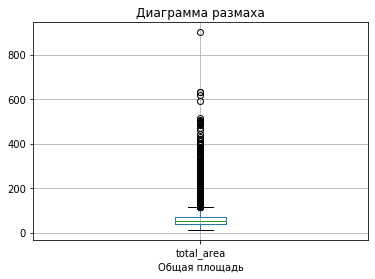

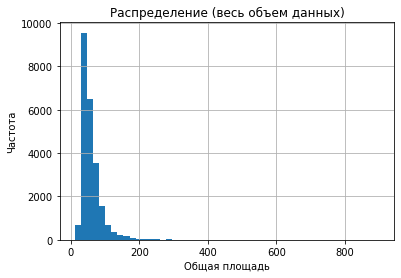

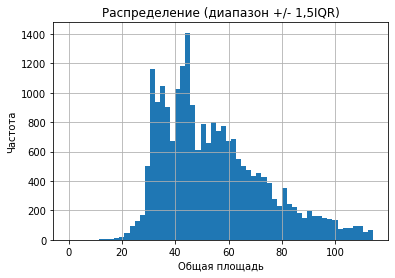

In [512]:
def plots(data, parameter, 
          xlabel,
          boxplot = 1, 
          hist_a = 1, bins_a = 10, llimit_a = 0, rlimit_a = -1,  
          hist_b = 1, bins_b = 10):
    '''
    Функция определяет границы для построения гистограммы распределения
    Строит диаграмму размаха и две гистограммы: одну на всех данные, вторую на данных в диапазоне +/- 1,5IQR
    :data: датафрейм для анализа
    :parameter:  параметр датафрейма для постоения графиков
    :xlabel: подпись для оси x на всех графиках
    :boxplot: определяет выводить или нет boxplot 
    :hist_a: определяет выводить или нет гистогрмму, построенную на всем наборе данных
    :bins_a: количество корзин для построения гистрограммы на всем наборе данных
    :llimit_a: левая граница для построения гистрограммы на всем наборе данных
    :rlimit_a: правая граница для построения гистрограммы на всем наборе данных. Определяет, как задаются границы: мануально/питоном.
    :hist_b: определяет выводить или нет гистогрмму, построенную в диапазоне +/- 1,5IQR. 
    :bins_b: количество корзин для построения гистрограммы в диапазоне +/- 1,5IQR
    '''
    data_describe = data[parameter].describe()
    q1 = data_describe.loc['25%']
    q3 = data_describe.loc['75%']
    iqr = q3 - q1
    if q1 - 1.5 * iqr < 0:
        llimit_b = 0
    else:
        llimit_b = q1 - 1.5 * iqr
    rlimit_b = q3 + 1.5 * iqr
    
    if boxplot == 1:
        data.boxplot(parameter)
        plt.title('Диаграмма размаха')
        plt.xlabel(xlabel)
        plt.show()
        
    if hist_a == 1:
        if rlimit_a == -1:
            data.hist(column = parameter, bins = bins_a)
        if rlimit_a != -1:
            data.hist(column = parameter, bins = bins_a, range = (llimit_a, rlimit_a))
        plt.title('Распределение (весь объем данных)')
        plt.xlabel(xlabel)
        plt.ylabel('Частота')
        plt.show()
        
    if hist_b == 1:
        data.hist(column = parameter, bins = bins_b, range = (llimit_b, rlimit_b))
        plt.title('Распределение (диапазон +/- 1,5IQR)')
        plt.xlabel(xlabel)
        plt.ylabel('Частота')
        plt.show()
    return iqr, llimit_b, rlimit_b


iqr, left_limit, right_limit = plots(
    data = data, 
    parameter = 'total_area', 
    xlabel = 'Общая площадь', 
    bins_a = 50, 
    bins_b = 60)

Примерно до 100м2 распределение близко к нормальному, но есть явный перевес квартир с небольшим метражом: до 45м2. Изменяя количество бинов, обнаружили главные пики: 33м2 и 45м2. Следующий, уже не такой явный пик, приходится на 58м2. 

*Это конечно не цель анализа, но наблюдение любопытное: пики соответстсвует метражу однушек, двушек и трешек в стандартных хрущевках ;)* 

Есть объекты, с площадью менее 20м2 и более 300м2. Самый значительный выброс — 900м2.

In [513]:
outliners_amt = (
    data
    .query('total_area < @left_limit or total_area > @right_limit')['total_area']
    .count()
)

outliners_perc = outliners_amt/data['total_images'].count()
print('Количество выбросов total_area:', outliners_amt)
print('Это {:.2%}'.format(outliners_perc))

Количество выбросов total_area: 1239
Это 5.26%


Проверим, как влияет на харакетер распределения большой город

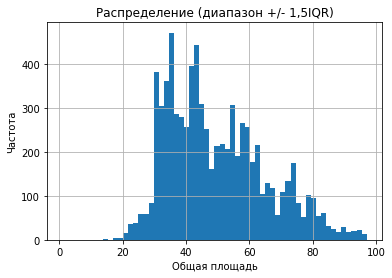

(24.0, 1.0, 97.0)

In [514]:
#создаем датасет, в котором нет Санкт-Петербурга - он нам еще пригодится
df3 = data.loc[data['locality_name'] != 'САНКТ-ПЕТЕРБУРГ']

plots(
    data = df3, parameter = 'total_area', 
    xlabel = 'Общая площадь', 
    boxplot = 0, 
    hist_a = 0, 
    hist_b = 1, bins_b = 60
)

Характер распределения не изменился


> **<span style="color:green">Крайне крутая функция для определения границ выбросов. Также круто, что ты перед очисткой данных от выбросов, проверяешь объем данных, которые собираешься удалить. Браво! </span>**
>
> **<span style="color:red">Но нужно добавить подписи осей и названия для графиков (это замечание касается всех графиков в твоей работе). Также в среде аналитиков принято подобные однотипные построения гистограмм и графиков автоматизировать с помощью функций и/или циклов. Попробуй, пожалуйста, реализовать подобный подход в своей работе, тем более ты можешь просто дополнить свою функцию с поиском границ выбросов, добавив в функцию дополнительные аргументы (названия для графиков, подписи, количество корзин `bins`) и непосредственно сам вывод графиков.</span>**
>
> Дополнила функцию. Не слишком ли она получилась тяжелая и усложненная? Меня также смущает, что она и графики строит, и переменным значения присваивает. Выглядит диковато. Стоит ли разделить эти две части на разные функции?

###  Стоимость

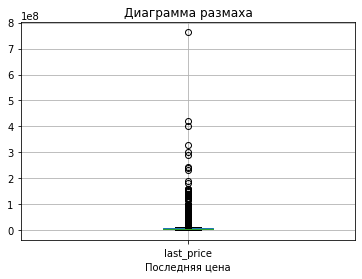

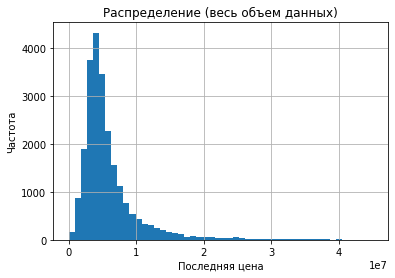

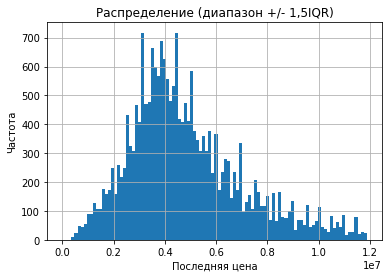

In [515]:
iqr, left_limit, right_limit = plots(
    data = data, parameter = 'last_price', 
    xlabel = 'Последняя цена', 
    bins_a = 50, rlimit_a = 45000000,   
    bins_b = 100)

Минимальное значение около 12500 руб. — явный выброс. Основная масса призодится на диапазон от 400 000 руб. до 12 000 000 руб. Но есть и заметные значения вплоть до 40 000 000 руб. 

In [516]:
outliners_amt = (
    data
    .query('last_price < @left_limit or last_price > @right_limit')['last_price']
    .count()
)

outliners_perc = outliners_amt/data['total_images'].count()
print('Количество выбросов last_price:', outliners_amt)
print('Это {:.2%}'.format(outliners_perc))

Количество выбросов last_price: 2046
Это 8.68%


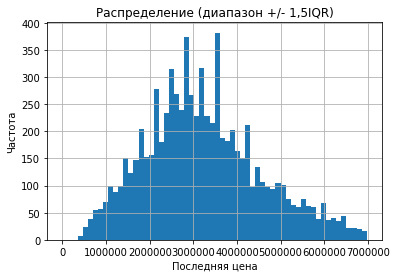

(1850000.0, 0, 6975000.0)

In [517]:
plots(
    data = df3, parameter = 'last_price', 
    xlabel = 'Последняя цена', 
    boxplot = 0, 
    hist_a = 0, 
    hist_b = 1, bins_b = 60)

При исключении Санкт-Петербурга распределение сместилось в сторону меньшей стоимости, сохранив характер

In [518]:
print('Минимальная цена-не выброс по всему датасету')
data.loc[data['last_price'] > data['last_price'].describe()['min']]['last_price'].min()

Минимальная цена-не выброс по всему датасету


430000.0

### Количество комнат

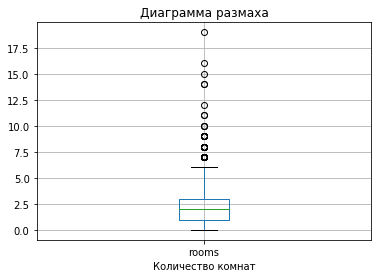

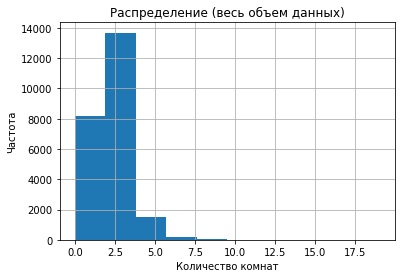

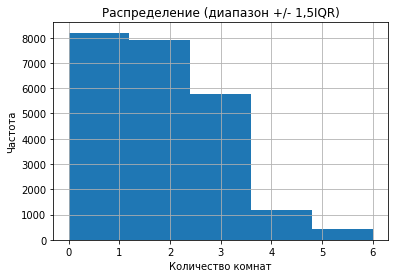

In [519]:
iqr, left_limit, right_limit = plots(
    data = data, parameter = 'rooms', 
    xlabel = 'Количество комнат', 
    bins_a = 10, 
    bins_b = 5)

Самые частые варианты: 1 и 2 комнаты. Есть странное значение в 0 комнат. 

In [520]:
outliners_amt = (
    data
    .query('rooms < @left_limit or rooms > @right_limit')['rooms']
    .count()
)

zero_amt = (
    data
    .query('rooms == 0')['rooms']
    .count()
)

outliners_perc = outliners_amt/data['total_images'].count()
print('Количество выбросов rooms:', outliners_amt)
print('Это {:.2%}'.format(outliners_perc))
print('Количество нулей rooms:', zero_amt)

Количество выбросов rooms: 90
Это 0.38%
Количество нулей rooms: 194


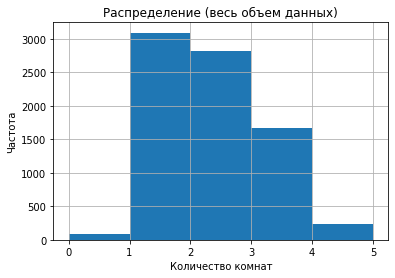

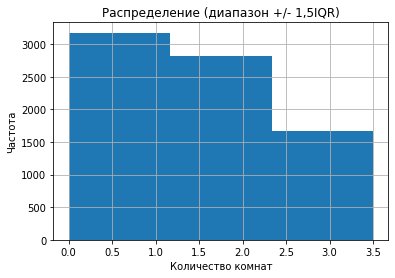

(1.0, 0, 3.5)

In [521]:
plots(
    data = df3, parameter = 'rooms', 
    xlabel = 'Количество комнат', 
    boxplot = 0, 
    hist_a = 1, rlimit_a = 5, bins_a = 5,
    hist_b = 1, bins_b = 3)

При исключеии Санкт-Петербурга IQR  изменился, но 1- и 2-комнатные все равно самые частовстречаемые.

Посмотрим, достоверные ли данные по тем объектам, где больше 7 комнат? Все очень похоже на правду

In [522]:
data.loc[data['rooms'] > 7]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_type,price_per_msqr,day_of_week_exposition,month_exposition,year_exposition,floor_mark,living_of_total_area,kitchen_of_total_area
648,3,17500000.0,183.7,2018-07-01,11,3.40,7,138.8,7,False,False,False,13.300000,0,САНКТ-ПЕТЕРБУРГ,23606.0,3148.0,0,NaN,0,NaN,306,город,95264.017420,6,7,2018,последний,0.755580,0.072401
813,7,16500000.0,229.0,2016-02-25,8,NaN,6,160.0,5,False,False,False,25.000000,0,САНКТ-ПЕТЕРБУРГ,23968.0,4536.0,1,243.0,0,NaN,806,город,72052.401747,3,2,2016,другой,0.698690,0.109170
866,5,25000000.0,363.0,2017-12-23,14,3.16,5,222.0,4,False,False,False,16.600000,0,САНКТ-ПЕТЕРБУРГ,38076.0,7950.0,0,NaN,2,435.0,418,город,68870.523416,5,12,2017,другой,0.611570,0.045730
4149,6,23000000.0,272.6,2018-01-11,10,3.14,7,145.9,7,False,False,False,18.800000,1,САНКТ-ПЕТЕРБУРГ,10726.0,12169.0,1,191.0,1,531.0,477,город,84372.707263,3,1,2018,последний,0.535216,0.068966
4435,13,22190000.0,191.2,2017-12-05,8,2.90,6,115.8,1,False,False,False,5.000000,0,САНКТ-ПЕТЕРБУРГ,21589.0,1152.0,1,587.0,2,155.0,115,город,116056.485356,1,12,2017,первый,0.605649,0.026151
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6,409.0,3,False,False,False,100.000000,0,САНКТ-ПЕТЕРБУРГ,24447.0,4666.0,1,767.0,0,NaN,14,город,110169.491525,3,2,2019,другой,0.693220,0.169492
7857,11,150000000.0,230.0,2017-10-25,8,NaN,8,220.0,8,False,False,False,43.088108,0,САНКТ-ПЕТЕРБУРГ,25525.0,5845.0,2,116.0,0,NaN,135,город,652173.913043,2,10,2017,последний,0.956522,0.187340
8758,5,16100000.0,150.0,2018-07-10,8,2.92,5,107.0,1,False,False,False,7.200000,0,САНКТ-ПЕТЕРБУРГ,26080.0,4782.0,2,473.0,0,NaN,297,город,107333.333333,1,7,2018,первый,0.713333,0.048000
8822,14,49968900.0,398.0,2017-07-12,9,3.00,2,160.1,1,False,False,False,41.000000,0,САНКТ-ПЕТЕРБУРГ,17720.0,16722.0,3,471.0,2,440.0,471,город,125550.000000,2,7,2017,первый,0.402261,0.103015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Высота потолка

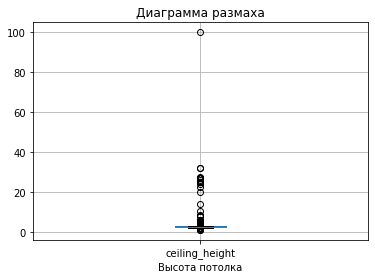

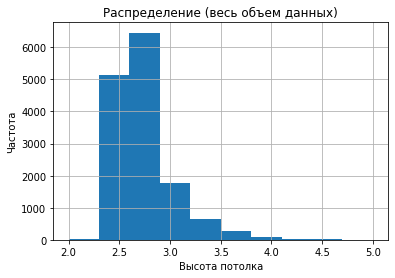

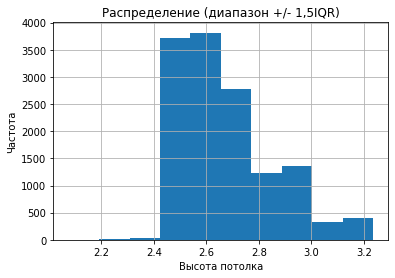

In [523]:
iqr, left_limit, right_limit = plots(
    data = data, 
    parameter = 'ceiling_height', 
    xlabel = 'Высота потолка',  
    bins_a = 10, llimit_a = 2, rlimit_a = 5,
    bins_b = 10)

В лидерах стандартные 2,65 метра. Явный выброс: значение 100 метров.

In [524]:
outliners_amt = (
    data
    .query('ceiling_height < @left_limit or ceiling_height > @right_limit')['ceiling_height']
    .count()
)


outliners_perc = outliners_amt/data['total_images'].count()
print('Количество выбросов ceiling_height:', outliners_amt)
print('Это {:.2%}'.format(outliners_perc))

Количество выбросов ceiling_height: 819
Это 3.48%


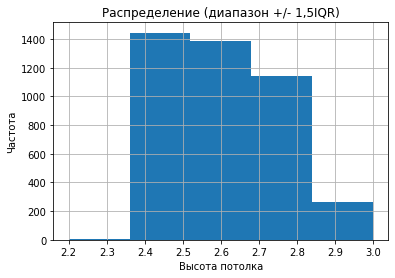

(0.20000000000000018, 2.1999999999999997, 3.0000000000000004)

In [525]:
plots(data = df3, parameter = 'ceiling_height', 
      xlabel = 'Высота потолка', 
      boxplot = 0, 
      hist_a = 0, 
      hist_b = 1, bins_b = 5)

При исключеии Санкт-Петербурга потолки снижаются...

### 4.2 Изучите время продажи квартиры. 
Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

In [526]:
days_exposition_describe = data['days_exposition'].describe()
days_exposition_describe

count    23565.000000
mean       185.759728
std        233.492930
min          0.000000
25%         43.000000
50%         94.000000
75%        237.000000
max       1618.000000
Name: days_exposition, dtype: float64

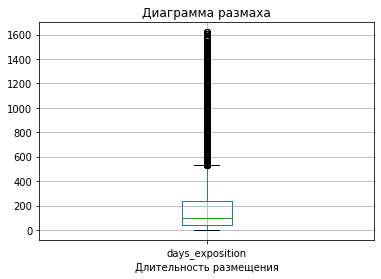

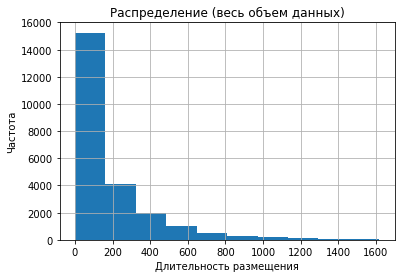

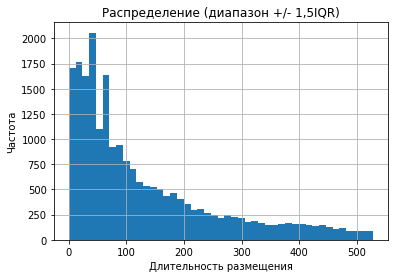

In [527]:
iqr, left_limit, right_limit = plots(data = data, parameter = 'days_exposition', 
                                     xlabel = 'Длительность размещения', 
                                     bins_a = 10, bins_b = 45)

In [528]:
days_exposition_1q = days_exposition_describe.loc['25%']
days_exposition_3q = days_exposition_describe.loc['75%']
data.query('days_exposition < @days_exposition_1q')['total_images'].count()

5846

In [529]:
data.query('days_exposition >= @days_exposition_3q')['total_images'].count()

5897

В среднем продажа квартриры заниимает 185 дней (то есть примерно полгода). Но медиана говорит о том, что продажа происходит за 94 дня (три месяца). На эту разницу влияют значения, находящиеся за Q3+1,5IQR. Также есть пики на значениях ~50 дней.
Можно считать, что все, что продано быстрее первого квартиля (43 дней) — продано быстро. А все, что продавалось дольше третьего квартиля (237 дней) — это долго.


> **<span style="color:green">Здесь все аргументировано и по делу.</span>**

### 4.3 Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.

In [530]:
#исключаем значения: 
#ограничение снизу: квартир с площадью менее 20 метров не так много, 
#по многим из этих объектов были пропуски по другим полям
#ограничение сверху: начиная с 400 м2 на гистограмме значительно меньше значний
good_data = data.query('total_area > 20 and total_area < 400')

#ограничение снизу: первое после неадекватного минимума значение
#ограничение сверху: начиная с 45000000 на гистограмме не видно значний
good_data = good_data.query('last_price >= 430000 and last_price < 45000000')

#ограничение снизу: комнат должно быть больше нуля
#ограничение сверху: нет, так как количество комнат может быть любым 
#(проверили, что для объектов с большим количеством комнат остальные параметы соответсвуют по логике)
good_data = good_data.query('rooms > 0')

#ограничение снизу: разумное значение
#ограничение сверху: 99% квантиль
good_data = good_data.query('ceiling_height > 2.45 and ceiling_height < 4')

#ограничение снизу: уберем слишком быстрые продажи
#ограничение сверху: чтобы не убрать ничгео лишнего, оствим значение, в 2 раза больше третьего квартиля
#good_data = good_data.query('days_exposition > 1 and days_exposition < 400')
good_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14121 entries, 0 to 23698
Data columns (total 30 columns):
total_images              14121 non-null int64
last_price                14121 non-null float64
total_area                14121 non-null float64
first_day_exposition      14121 non-null datetime64[ns]
rooms                     14121 non-null int64
ceiling_height            14121 non-null float64
floors_total              14121 non-null int64
living_area               14121 non-null float64
floor                     14121 non-null int64
is_apartment              14121 non-null bool
studio                    14121 non-null bool
open_plan                 14121 non-null bool
kitchen_area              14121 non-null float64
balcony                   14121 non-null int64
locality_name             14121 non-null object
airports_nearest          14121 non-null float64
city_centers_nearest      14121 non-null float64
parks_around3000          14121 non-null int64
parks_nearest           


> **<span style="color:green">С обработкой выбросов у тебя тоже полный порядок. Единственный момент: я бы не стал удалять выбросы по колонке с количеством дней размещения объявления — все же это не ключевой параметр влияющий на стоимость объектов недвижимости.</span>**

> Убрала ограничение по времени продаж

### 4.4 Какие факторы больше всего влияют на стоимость квартиры? 

Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.

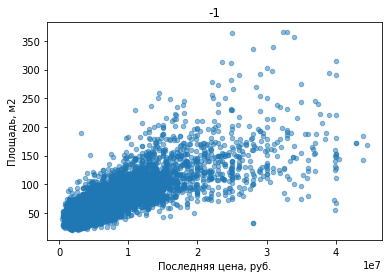

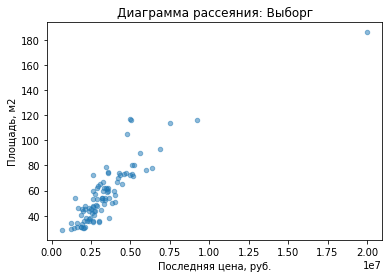

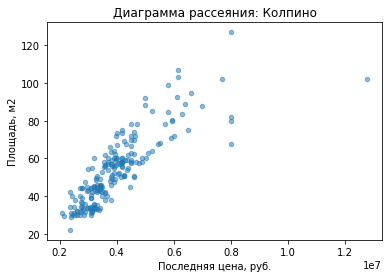

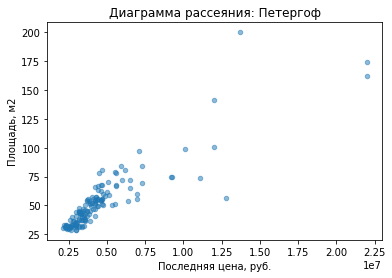

In [531]:
def scatter_plots(data, x_parameter, xlabel, y_parameter, ylabel, alpha, cities = [], title = -1):
    '''
    Строит диаграмму рассеяния для заданных величин по всему датасету.
    При передаче списка городов строит диаграммы для отдельного города.
    :data: датафрейм для анализа
    :x_parameter:  параметр датафрейма для оси x
    :y_parameter:  параметр датафрейма для оси y
    :xlabel: подпись для оси x на всех графиках
    :ylabel: подпись для оси y на всех графиках
    :alpha: определяет прозрачность точек на графике
    :cities: список городов 
    :title: определяет дефолтный заголовок или пользовательский
    '''
    data.plot.scatter(x = x_parameter, y = y_parameter, alpha = alpha)
    if title == -1:
        plt.title('Диаграмма рассеяния (весь объём данных)')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show
    
    for city in cities:
        data.loc[data['locality_name'] == city].plot.scatter(x = x_parameter, y = y_parameter, alpha = alpha)
        title = 'Диаграмма рассеяния: ' + city.capitalize() 
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
        

scatter_plots(
    data = good_data, 
    x_parameter = 'last_price', y_parameter = 'total_area',
    xlabel = 'Последняя цена, руб.', ylabel = 'Площадь, м2',
    alpha = 0.5,
    cities = ['ВЫБОРГ', 'КОЛПИНО', 'ПЕТЕРГОФ']
)

Цена зависит от площади на малых значениях, но чем больше площадь, тем меньше выражена зависимость. 

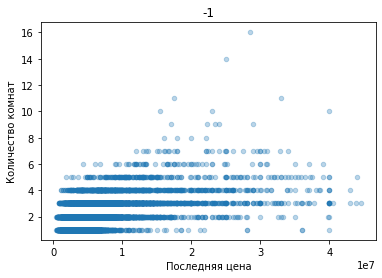

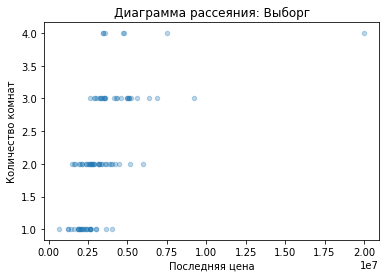

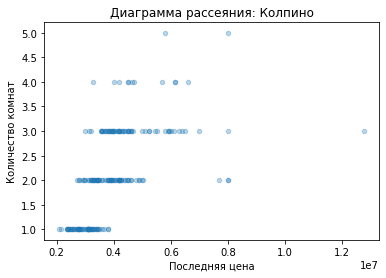

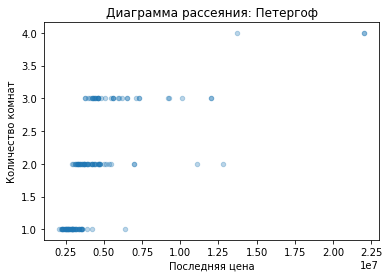

In [532]:
scatter_plots(
    data = good_data, 
    x_parameter = 'last_price', y_parameter = 'rooms',
    xlabel = 'Последняя цена', ylabel = 'Количество комнат',
    alpha = 0.3,
    cities = ['ВЫБОРГ', 'КОЛПИНО', 'ПЕТЕРГОФ']
)

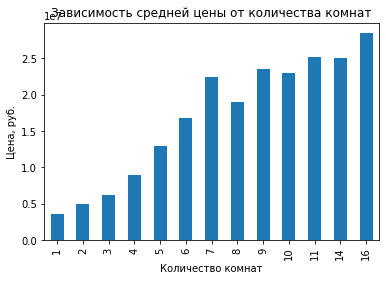

In [533]:
(
    good_data
    .groupby(['rooms'])['last_price']
    .median()
    .plot(kind = 'bar')
)


plt.title('Зависимость средней цены от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена, руб.')
plt.show()

Зависимость просматривается, но есть ощущение, что она не описывается этими двумя параметрами. Так как для квартир с одинаковым количеством комнат цена может отличаться в несколько раз. Очевидно, нужно смотреть в разрезе города/района.

При этом по средним значениям зависимость +/- линейная. 

In [534]:
#проверка есть ли одушки за такую цену — общий график заставил сомневаться, что данные ок
good_data.loc[(good_data['rooms'] == 1) & (good_data['last_price'] > 30000000)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_type,price_per_msqr,day_of_week_exposition,month_exposition,year_exposition,floor_mark,living_of_total_area,kitchen_of_total_area
8261,20,36000000.0,123.2,2018-01-14,1,3.00,14,31.2,7,False,False,False,58.4,1,САНКТ-ПЕТЕРБУРГ,28098.0,6800.0,2,84.0,3,234.0,61,город,292207.792208,6,1,2018,другой,0.253247,0.474026
8322,20,39900000.0,55.3,2017-10-26,1,3.05,6,35.0,4,False,False,False,8.0,4,САНКТ-ПЕТЕРБУРГ,25685.0,2136.0,1,72.0,3,202.0,554,город,721518.987342,3,10,2017,другой,0.632911,0.144665
15883,2,36000000.0,80.0,2018-11-21,1,3.40,7,33.0,6,False,False,False,22.0,0,САНКТ-ПЕТЕРБУРГ,33024.0,6116.0,2,51.0,3,296.0,27,город,450000.000000,2,11,2018,другой,0.412500,0.275000


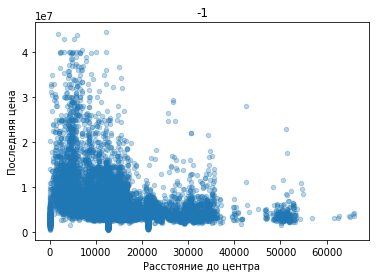

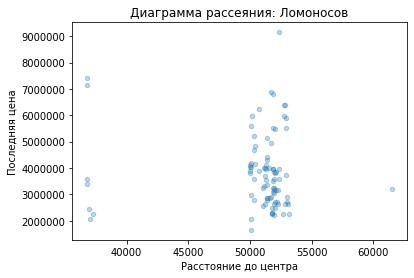

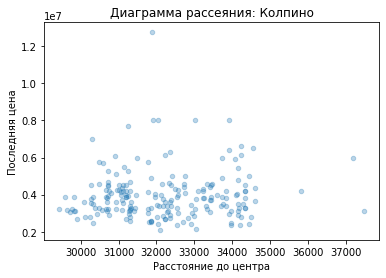

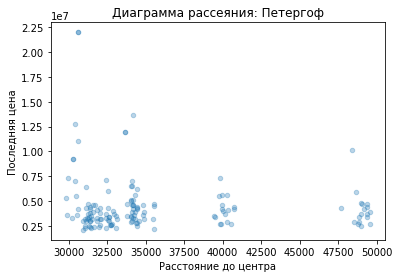

In [535]:
scatter_plots(
    data = good_data, 
    x_parameter = 'city_centers_nearest', y_parameter = 'last_price',
    xlabel = 'Расстояние до центра', ylabel = 'Последняя цена',
    alpha = 0.3,
    cities = ['ЛОМОНОСОВ', 'КОЛПИНО', 'ПЕТЕРГОФ']
)

Диапазон цен в случае блиозости к центру очень большой. При удалении от центра предложений с высокой ценой становится меньше. На полном объеме данных видно тренд отрицательной зависимости. 

In [536]:
good_data_floor = good_data.pivot_table(index = 'floor_mark', values = ['price_per_msqr','last_price'], aggfunc = 'median')
good_data_floor.columns = ['Цена, руб.', 'Цена/м2, руб']
good_data_floor.sort_values(by = 'Цена, руб.', ascending = False)

,"Цена, руб.","Цена/м2, руб"
floor_mark,,
другой,5000000.0,99744.245524
последний,4500000.0,89239.040529
первый,4100000.0,83373.015873


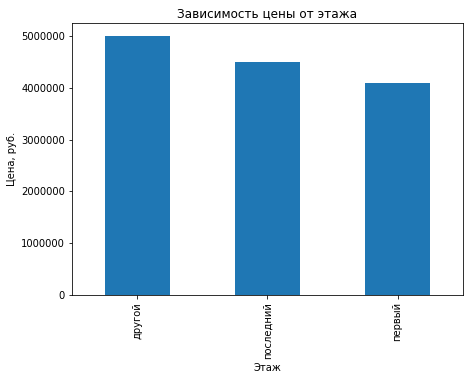

In [576]:
(
    good_data_floor
    .sort_values(by = 'Цена, руб.', ascending = False)
    .plot(y = 'Цена, руб.', kind ='bar', figsize = (7,5), legend = False)
)

plt.title('Зависимость цены от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена, руб.')
plt.show()

Самый классный этаж — другой этаж. Первый и последний не в почете. 

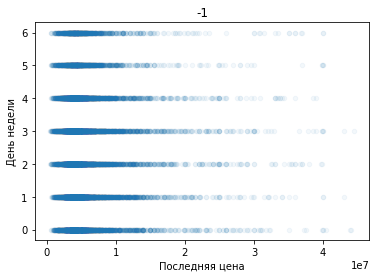

In [538]:
scatter_plots(
    data = good_data, 
    x_parameter = 'last_price', y_parameter = 'day_of_week_exposition',
    xlabel = 'Последняя цена', ylabel = 'День недели',
    alpha = 0.05
)

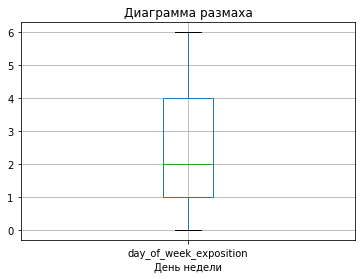

(3.0, 0, 8.5)

In [539]:
plots(
    data = good_data, parameter = 'day_of_week_exposition', 
    xlabel = 'День недели', 
          boxplot = 1, 
          hist_a = 0,   
          hist_b = 0
)

In [540]:
good_data.groupby(['day_of_week_exposition'])['last_price'].median()

day_of_week_exposition
0    4900000.0
1    5000000.0
2    4850000.0
3    4850000.0
4    4750000.0
5    4687500.0
6    4700000.0
Name: last_price, dtype: float64

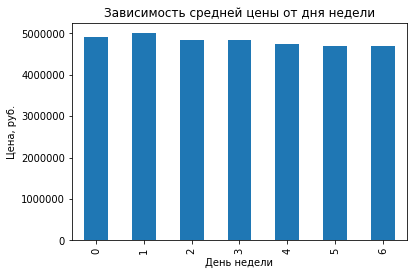

In [541]:
(
    good_data
    .groupby(['day_of_week_exposition'])['last_price']
    .median()
    .plot(kind = 'bar')
)


plt.title('Зависимость средней цены от дня недели')
plt.xlabel('День недели')
plt.ylabel('Цена, руб.')
plt.show()

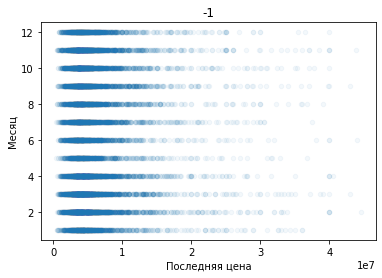

In [542]:
scatter_plots(
    data = good_data, 
    x_parameter = 'last_price', y_parameter = 'month_exposition',
    xlabel = 'Последняя цена', ylabel = 'Месяц',
    alpha = 0.05
)

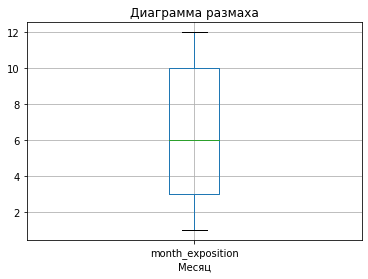

(7.0, 0, 20.5)

In [543]:
plots(
    data = good_data, parameter = 'month_exposition', 
    xlabel = 'Месяц', 
          boxplot = 1, 
          hist_a = 0,   
          hist_b = 0
)

In [544]:
good_data.groupby(['month_exposition'])['last_price'].median()

month_exposition
1     4900000.0
2     4900000.0
3     4700000.0
4     5000000.0
5     4800000.0
6     4600000.0
7     4900000.0
8     4900000.0
9     4840000.0
10    4750000.0
11    4850000.0
12    4900000.0
Name: last_price, dtype: float64

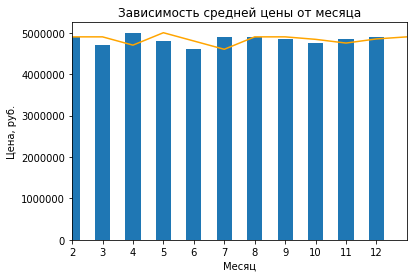

In [545]:
(
    good_data
    .groupby(['month_exposition'])['last_price']
    .median()
    .plot(kind = 'bar')
)

(
    good_data
    .groupby(['month_exposition'])['last_price']
    .median()
    .plot(color = 'orange')
)

plt.title('Зависимость средней цены от месяца')
plt.xlabel('Месяц')
plt.ylabel('Цена, руб.')
plt.show()

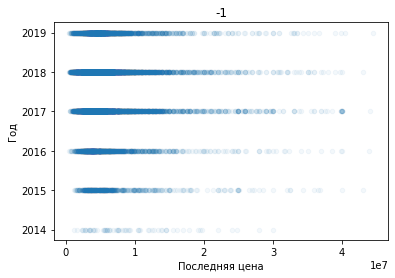

In [546]:
scatter_plots(
    data = good_data, 
    x_parameter = 'last_price', y_parameter = 'year_exposition',
    xlabel = 'Последняя цена', ylabel = 'Год',
    alpha = 0.05
)

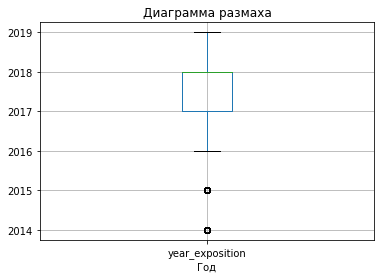

,year_exposition
count,14121.000000
mean,2017.513986
std,1.024677
min,2014.000000
25%,2017.000000
50%,2018.000000
75%,2018.000000
max,2019.000000


In [547]:
plots(
    data = good_data, parameter = 'year_exposition', 
    xlabel = 'Год', 
          boxplot = 1, 
          hist_a = 0,   
          hist_b = 0
)

good_data['year_exposition'].describe().to_frame()

In [548]:
good_data.groupby(['year_exposition'])['last_price'].median().to_frame()

,last_price
year_exposition,
2014,7500000.0
2015,5550000.0
2016,4800000.0
2017,4700000.0
2018,4700000.0
2019,5200000.0


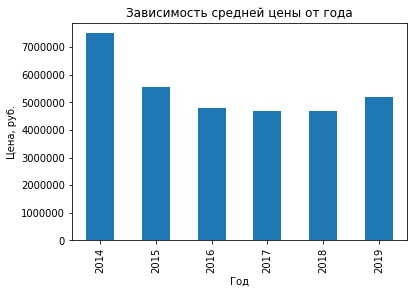

In [549]:
(
    good_data
    .groupby(['year_exposition'])['last_price']
    .median()
    .plot(kind = 'bar')
)

plt.title('Зависимость средней цены от года')
plt.xlabel('Год')
plt.ylabel('Цена, руб.')
plt.show()

интересно, что происходило в 2014? видимо, было не так много объяввлений с достаточной большой ценой. 

In [550]:
good_data.loc[good_data['year_exposition'] == 2014].groupby('month_exposition')['total_images'].count()

month_exposition
11    11
12    60
Name: total_images, dtype: int64

Дешевых квартир в любое время года и в любом году больше. В среднем цены на квартиры с 2015 года уменьшились, но в 2019 есть рост. Ярко выраженной сезонности нет, но в период с апреля по июнь в среднем цены меньше.


> **<span style="color:red">Кажется, подобные графики (скаттерплоты) не совсем понятно отражают характер зависимости для таких параметров как количество комнат, год, месяц и день недели. Для этих параметров можно посчитать также средние показатели стоимости и построить линейные или столбчатые диаграммы. В качестве альтернативы можно также использовать боксплоты — так мы увидим не только распределение, но и поймем в каких границах расположена основная часть объектов, узнаем средние значения и т.д. Также не забудь добавить подписи и названия для графиков. </span>**

> Достроила боксплоты и столбчатые. Зависимости стали понятнее :)

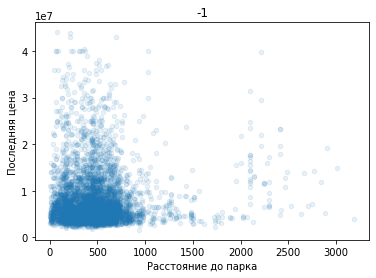

In [551]:
scatter_plots(
    data = good_data, 
    x_parameter = 'parks_nearest', y_parameter = 'last_price',
    xlabel = 'Расстояние до парка', ylabel = 'Последняя цена',
    alpha = 0.1
)

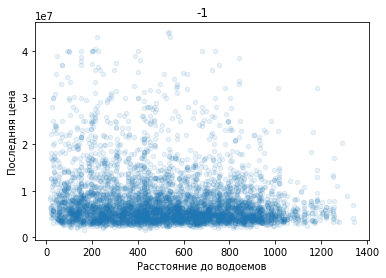

In [552]:
scatter_plots(
    data = good_data, 
    x_parameter = 'ponds_nearest', y_parameter = 'last_price',
    xlabel = 'Расстояние до водоемов', ylabel = 'Последняя цена',
    alpha = 0.1
)

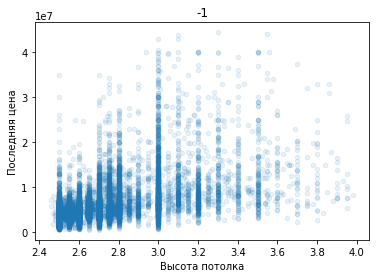

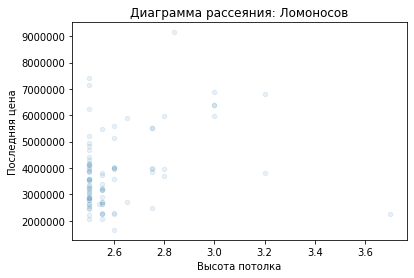

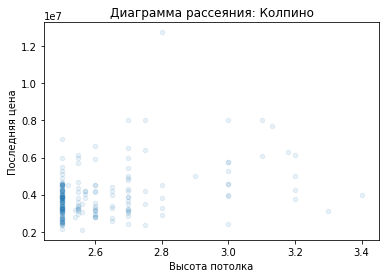

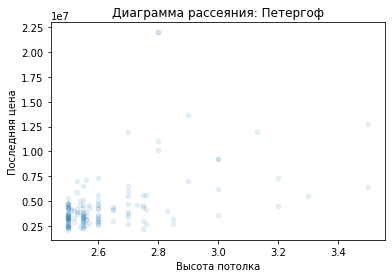

In [553]:
scatter_plots(
    data = good_data, 
    x_parameter = 'ceiling_height', y_parameter = 'last_price',
    xlabel = 'Высота потолка', ylabel = 'Последняя цена',
    alpha = 0.1,
    cities = ['ЛОМОНОСОВ', 'КОЛПИНО', 'ПЕТЕРГОФ']
)

In [554]:
good_data_corr = good_data.loc[:, 'last_price':'days_exposition']
good_data_corr.drop('locality_name', axis = 1, inplace = True)
good_data_corr.corr()['last_price'].sort_values(ascending = False).to_frame().style.background_gradient(cmap='Blues')

,last_price
last_price,1
total_area,0.793479
living_area,0.699576
kitchen_area,0.609887
ceiling_height,0.523696
rooms,0.51893
ponds_around3000,0.286201
parks_around3000,0.285854
days_exposition,0.1514
floor,0.0793018


In [555]:
### Код ревьювера ###

# для наглядности можно использовать функции style пакета pandas

(good_data_corr
     .corr()['last_price']
     .sort_values(ascending = False)
     .to_frame()
     .style
     .background_gradient(cmap='Greens')
)

,last_price
last_price,1
total_area,0.793479
living_area,0.699576
kitchen_area,0.609887
ceiling_height,0.523696
rooms,0.51893
ponds_around3000,0.286201
parks_around3000,0.285854
days_exposition,0.1514
floor,0.0793018


In [556]:
good_data_corr = good_data.loc[:, 'last_price':'days_exposition']

(
    good_data_corr
    .query('locality_name == "САНКТ-ПЕТЕРБУРГ"')
    .corr()['last_price']
    .sort_values(ascending = False)
    .to_frame()
    .style
    .background_gradient(cmap = 'Greens')
)

,last_price
last_price,1
total_area,0.81101
living_area,0.71659
kitchen_area,0.621978
rooms,0.542076
ceiling_height,0.51101
ponds_around3000,0.221236
parks_around3000,0.209882
days_exposition,0.202869
balcony,0.0300235


Основные параметры, которые оказывают влияние на рост цены:       
- total_area             
- living_area            
- kitchen_area          
- rooms              
- ceiling_height       

на снижение цены:
- open_plan
- studio 
- удаленность от центра
- удаленность от аэропорта
- удаленность от водоемов

Чем дальше аэропот, тем ниже стоимость. Чем ближе центр — тем стоимость выше. Водоемы и парки — это хорошо.


> **<span style="color:green">В целом по этому блоку все хорошо, отдельно хочу похвалить тебя за то, что проверяешь зависимости и на других населенных пунктах. </span>**

> Безумная красота с градиентом. Спасибо! 

### 4.5 Выберите 10 населённых пунктов с наибольшим числом объявлений. 

Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.

In [557]:
top_locality = good_data.groupby('locality_name')['total_images'].count().sort_values(ascending = False).head(10)

(
    good_data
    .query('locality_name in @top_locality.index')
    .groupby('locality_name')['price_per_msqr']
    .mean()
    .sort_values(ascending = False)
    
)

locality_name
САНКТ-ПЕТЕРБУРГ      112465.413206
ПУШКИН               103343.619603
СЕСТРОРЕЦК           101769.856441
ПОСЁЛОК ПАРГОЛОВО     90977.423171
ПОСЁЛОК МУРИНО        87310.007093
ПЕТЕРГОФ              85554.144673
ПОСЁЛОК ШУШАРЫ        79244.869320
КОЛПИНО               75973.424752
ГАТЧИНА               70144.986616
ВСЕВОЛОЖСК            67176.172302
Name: price_per_msqr, dtype: float64

Самая высокая стоимость жилья в Санкт-Петербурге, самая низкая — в Выборге. 


> **<span style="color:green">Здесь всё верно.</span>**

### 4.6 Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. 

Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.

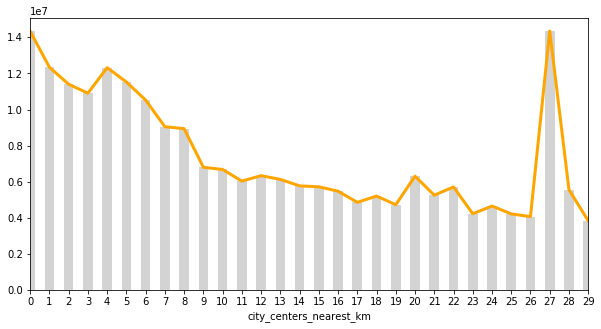

In [558]:
good_data['city_centers_nearest_km'] = good_data['city_centers_nearest']/1000
good_data['city_centers_nearest_km'] = good_data['city_centers_nearest_km'].astype('int')

good_data_spb = good_data.query('locality_name == "САНКТ-ПЕТЕРБУРГ"')

avg_price_per_km = good_data_spb.groupby('city_centers_nearest_km')['last_price'].mean()

avg_price_per_km.plot(kind = 'bar', figsize = (10,5), color = 'lightgrey')
avg_price_per_km.plot(color = 'orange', linewidth = 3)


После 4 км цена начинает падать. График сильно меняется после 8км. Будем считать центром все, что в пределах 8 километровой зоны. Интересно, что там на 3 км происходит? Может, промзона.


> **<span style="color:green">По выбору центрального радиуса Санкт-Петербурга полностью соглашусь. Действительно, после 4 километра наблюдается практически линейный тренд на снижение стоимости объектов. Также отмечу правдоподобность твоей гипотезы касательно спада на 3 километрах (возможно ветхое жилье). </span>**

In [559]:
good_data_spb.loc[good_data_spb['city_centers_nearest_km'] == 27]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_type,price_per_msqr,day_of_week_exposition,month_exposition,year_exposition,floor_mark,living_of_total_area,kitchen_of_total_area,city_centers_nearest_km
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,False,False,25.0,0,САНКТ-ПЕТЕРБУРГ,23888.0,27313.0,1,1496.0,0,NaN,128,город,193918.918919,1,11,2017,другой,0.405405,0.337838,27


На 27 км есть 1 дорогой объект. Очень похоже на ошибку в данных: словно в цене лишний 0.

### 4.7 Выделите сегмент квартир в центре. 

Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

In [560]:
good_data_spb_center = good_data_spb.query('city_centers_nearest_km <= 8')

good_data_spb_center[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,2683.000000,2.683000e+03,2683.000000,2683.000000
mean,84.099668,1.095013e+07,2.733507,3.007328
std,42.684851,7.105532e+06,1.335632,0.313656
min,20.300000,1.600000e+06,1.000000,2.460000
25%,54.000000,6.300000e+06,2.000000,2.765000
50%,75.000000,8.650000e+06,3.000000,3.000000
75%,102.000000,1.298000e+07,3.000000,3.200000
max,363.000000,4.400000e+07,16.000000,3.980000


In [561]:
good_data_spb[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,9825.000000,9.825000e+03,9825.000000,9825.000000
mean,63.794830,7.321353e+06,2.209669,2.748763
std,33.047291,5.182057e+06,1.110730,0.264583
min,20.300000,1.200000e+06,1.000000,2.460000
25%,42.200000,4.300000e+06,1.000000,2.550000
50%,55.700000,5.600000e+06,2.000000,2.700000
75%,75.000000,8.210000e+06,3.000000,2.830000
max,365.000000,4.450000e+07,16.000000,3.980000


Площадь квартир в центре больше. Маленькие квартиры в центре тоже встречаются. Цены в среднем больше. Больше комнат. Выше потолки.

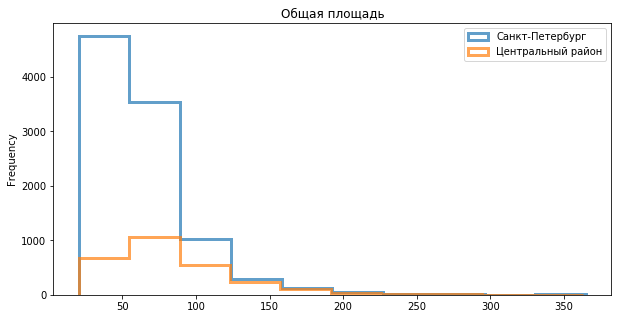

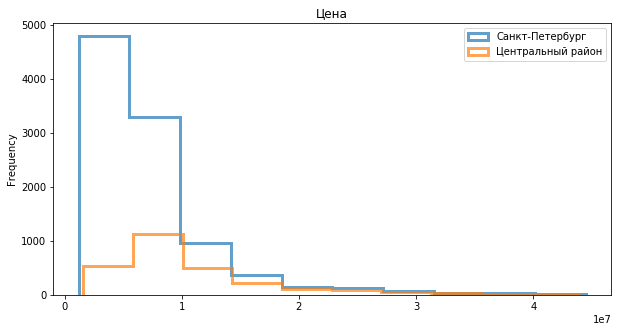

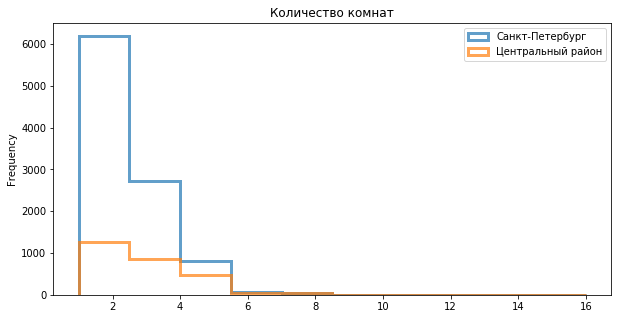

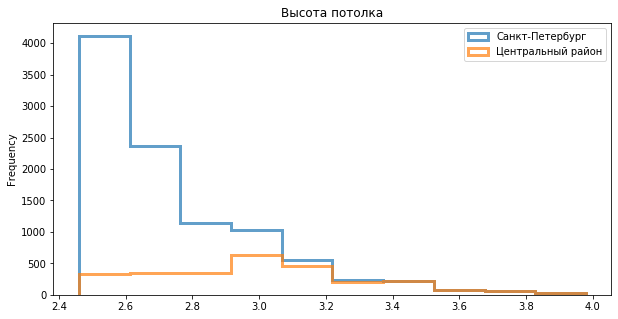

In [562]:
parameters = pd.DataFrame(
    (['total_area', 'Общая площадь'],
     ['last_price', 'Цена'], 
     ['rooms', 'Количество комнат'],
     ['ceiling_height', 'Высота потолка']),
     columns=['name_en', 'name_ru']
)


for parameter in range (0, len(parameters)):
    ax = (
        good_data_spb.plot(
            y = parameters['name_en'][parameter], 
            kind = 'hist', 
            histtype = 'step', 
            linewidth = 3, 
            alpha = 0.7, 
            label = 'Санкт-Петербург',
            figsize = (10,5)) 
    )
    
    good_data_spb_center.plot(
            y = parameters['name_en'][parameter], 
            kind = 'hist', 
            histtype = 'step', 
            linewidth = 3, 
            alpha = 0.7, 
            label = 'Центральный район', 
            ax=ax) 
    plt.title(parameters['name_ru'][parameter])


> **<span style="color:orange">Было бы круто добавить сюда гистограммы, или построить их с наложением друг на друга (Центр и все остальные объекты) </span>**
> Достроила

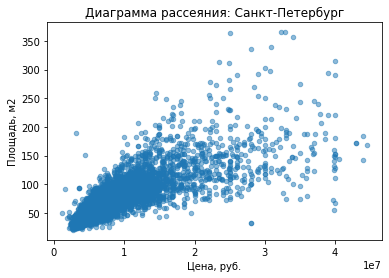

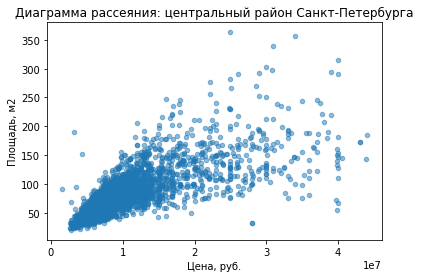

In [563]:
scatter_plots(
    data = good_data_spb, 
    x_parameter = 'last_price', xlabel = 'Цена, руб.', 
    y_parameter = 'total_area', ylabel = 'Площадь, м2', 
    alpha = 0.5,
    title = 'Диаграмма рассеяния: Санкт-Петербург')

scatter_plots(
    data = good_data_spb_center, 
    x_parameter = 'last_price', xlabel = 'Цена, руб.', 
    y_parameter = 'total_area', ylabel = 'Площадь, м2', 
    alpha = 0.5,
    title = 'Диаграмма рассеяния: центральный район Санкт-Петербурга')



Зависимость цена-площадь для центра города более выражена в начале числовой оси. Зависимость становится менее явной раньше, чем по городу в целом. 

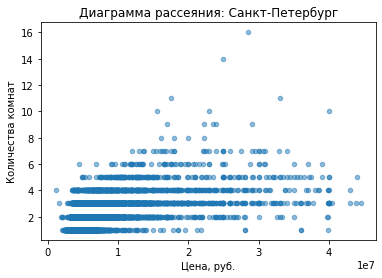

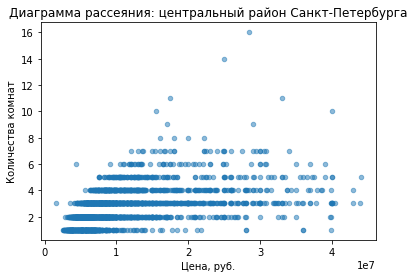

In [564]:
scatter_plots(
    data = good_data_spb, 
    x_parameter = 'last_price', xlabel = 'Цена, руб.', 
    y_parameter = 'rooms', ylabel = 'Количества комнат', 
    alpha = 0.5,
    title = 'Диаграмма рассеяния: Санкт-Петербург')

scatter_plots(
    data = good_data_spb_center, 
    x_parameter = 'last_price', xlabel = 'Цена, руб.', 
    y_parameter = 'rooms', ylabel = 'Количества комнат', 
    alpha = 0.5,
    title = 'Диаграмма рассеяния: центральный район Санкт-Петербурга')


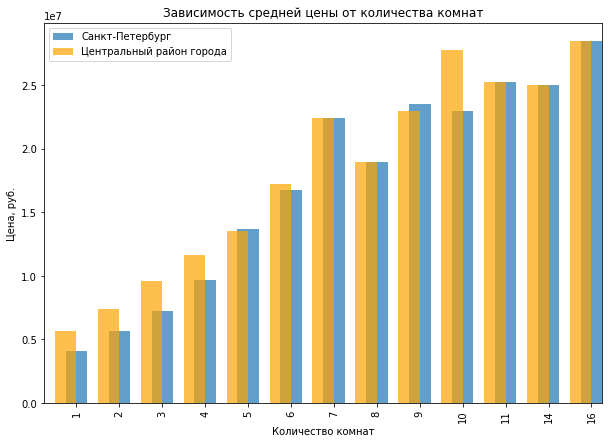

In [565]:
ax = (
    good_data_spb
    .groupby(['rooms'])['last_price']
    .median()
    .plot(kind = 'bar', label = 'Санкт-Петербург', figsize = (10, 7), alpha = 0.7, legend = True)
)

(
    good_data_spb_center
    .groupby(['rooms'])['last_price']
    .median()
    .plot(kind = 'bar', label = 'Центральный район города', color = 'orange', position = 1, alpha = 0.7,legend = True, ax = ax)
)


plt.title('Зависимость средней цены от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена, руб.')
plt.show()

Для центра зависимость цены от кличества комнат более ярко выражена, чем для города в целом. Характер сохраняется.

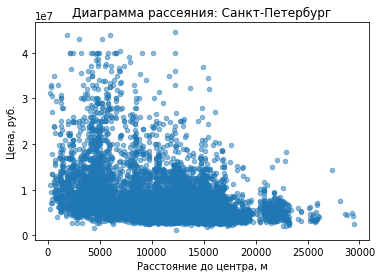

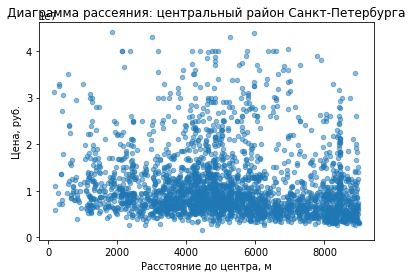

In [566]:
scatter_plots(
    data = good_data_spb, 
    x_parameter = 'city_centers_nearest', xlabel = 'Расстояние до центра, м', 
    y_parameter = 'last_price', ylabel = 'Цена, руб.', 
    alpha = 0.5,
    title = 'Диаграмма рассеяния: Санкт-Петербург')

scatter_plots(
    data = good_data_spb_center, 
    x_parameter = 'city_centers_nearest', xlabel = 'Расстояние до центра, м', 
    y_parameter = 'last_price', ylabel = 'Цена, руб.', 
    alpha = 0.5,
    title = 'Диаграмма рассеяния: центральный район Санкт-Петербурга')

В центральной зоне цены нет зависимости цены от расстояния. Просто дорогих предложений меньше, чем менее дорогих. А еще в самом центре мало предложений. 

In [567]:
good_data_floor_spb = good_data_spb.pivot_table(index = 'floor_mark', values = ['price_per_msqr','last_price'], aggfunc = 'median')
good_data_floor_spb.columns = ['Цена, руб.', 'Цена/м2, руб']
good_data_floor_spb.sort_values(by = 'Цена, руб.', ascending = False)

,"Цена, руб.","Цена/м2, руб"
floor_mark,,
последний,5800000.0,102500.000000
другой,5700000.0,107314.196963
первый,5000000.0,93545.716727


In [568]:
good_data_floor_spb_center = good_data_spb_center.pivot_table(index = 'floor_mark', values = ['price_per_msqr','last_price'], aggfunc = 'median')
good_data_floor_spb_center.columns = ['Цена, руб.', 'Цена/м2, руб']
good_data_floor_spb_center.sort_values(by = 'Цена, руб.', ascending = False)

,"Цена, руб.","Цена/м2, руб"
floor_mark,,
другой,9000000.0,124144.254991
последний,8800000.0,114031.250000
первый,6490000.0,106060.606061


Text(0, 0.5, 'Цена, руб.')

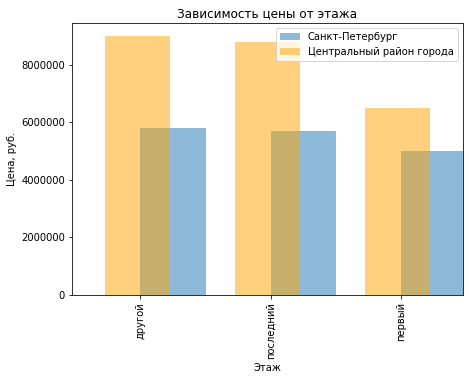

In [569]:
ax = (
    good_data_floor_spb
    .sort_values(by = 'Цена, руб.', ascending = False)
    .plot(y = 'Цена, руб.', label = 'Санкт-Петербург', kind ='bar', figsize = (7,5), legend = True, alpha = 0.5, position = 0)
)

(
    good_data_floor_spb_center
    .sort_values(by = 'Цена, руб.', ascending = False)
    .plot(y = 'Цена, руб.', kind = 'bar', label = 'Центральный район города',  ax = ax, color = 'orange', alpha = 0.5, position = 0.55)
)

plt.title('Зависимость цены от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена, руб.')


Цена выше, а предпочтения те же: другой этаж по-прежнему лидер.

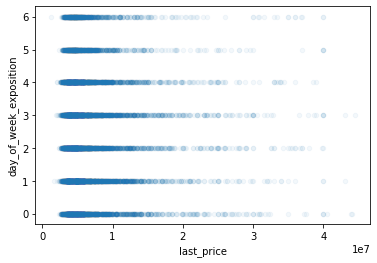

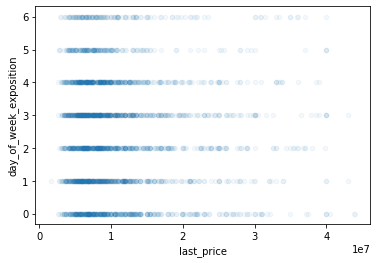

In [570]:
good_data_spb.plot.scatter(x = 'last_price', y = 'day_of_week_exposition', alpha = 0.05)
plt.show()
good_data_spb_center.plot.scatter(x = 'last_price', y = 'day_of_week_exposition', alpha = 0.05)

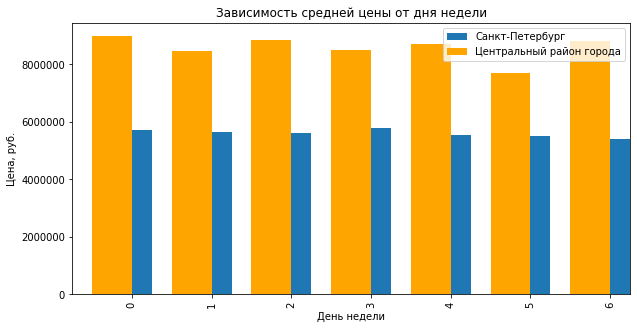

In [571]:
(
    good_data_spb
    .groupby(['day_of_week_exposition'])['last_price']
    .median()
    .plot(kind = 'bar', legend = True, label = 'Санкт-Петербург', figsize = (10, 5))
)

(
    good_data_spb_center
    .groupby(['day_of_week_exposition'])['last_price']
    .median()
    .plot(kind = 'bar', color = 'orange', position = 1, legend = True, label = 'Центральный район города')
)


plt.title('Зависимость средней цены от дня недели')
plt.xlabel('День недели')
plt.ylabel('Цена, руб.')
plt.show()

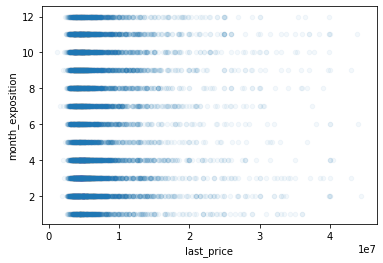

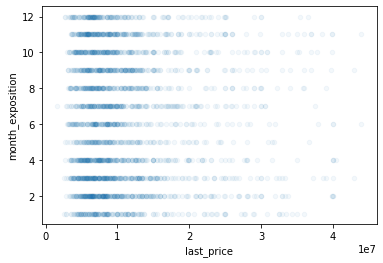

In [572]:
good_data_spb.plot.scatter(x = 'last_price', y = 'month_exposition', alpha = 0.05)
plt.show()
good_data_spb_center.plot.scatter(x = 'last_price', y = 'month_exposition', alpha = 0.05)

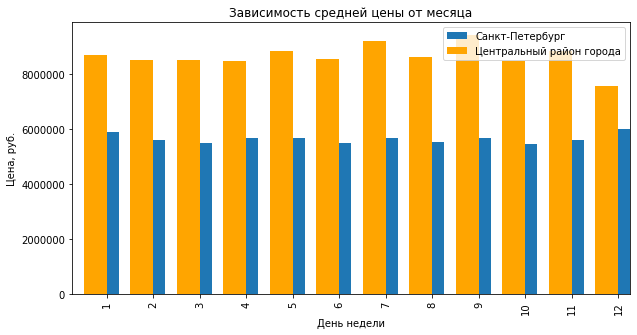

In [573]:
(
    good_data_spb
    .groupby(['month_exposition'])['last_price']
    .median()
    .plot(kind = 'bar', legend = True, label = 'Санкт-Петербург', figsize = (10, 5))
)

(
    good_data_spb_center
    .groupby(['month_exposition'])['last_price']
    .median()
    .plot(kind = 'bar', color = 'orange', position = 1, legend = True, label = 'Центральный район города')
)


plt.title('Зависимость средней цены от месяца')
plt.xlabel('День недели')
plt.ylabel('Цена, руб.')
plt.show()

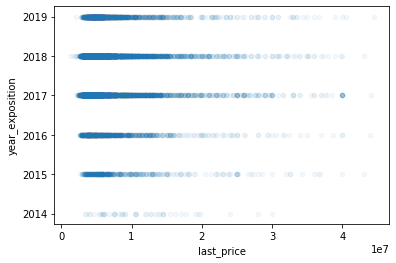

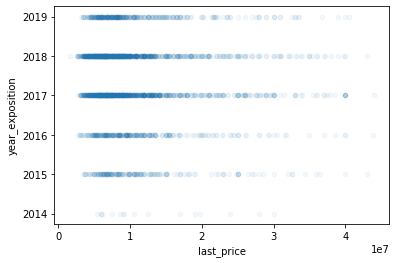

In [574]:
good_data_spb.plot.scatter(x = 'last_price', y = 'year_exposition', alpha = 0.05)
plt.show()
good_data_spb_center.plot.scatter(x = 'last_price', y = 'year_exposition', alpha = 0.05)

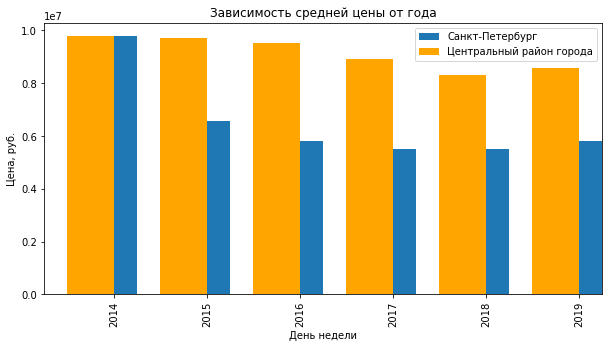

In [575]:
(
    good_data_spb
    .groupby(['year_exposition'])['last_price']
    .median()
    .plot(kind = 'bar', legend = True, label = 'Санкт-Петербург', figsize = (10, 5))
)

(
    good_data_spb_center
    .groupby(['year_exposition'])['last_price']
    .median()
    .plot(kind = 'bar', color = 'orange', position = 1, legend = True, label = 'Центральный район города')
)


plt.title('Зависимость средней цены от года')
plt.xlabel('День недели')
plt.ylabel('Цена, руб.')
plt.show()

И время года никак не влияет.


> **<span style="color:red">Здесь все хорошо, но опять же нужно получше подобрать графики для некоторых зависимостей. Поправь, пожалуйста. </span>**
> Поправила.

## Шаг 5. Общий вывод

### Установить наиболее характерные параметры, влияющие на цену квартиры

Основные параметры, которые оказывают влияние на рост цены (в порядке приоритета):       
- Общая площадь             
- Жилая площадь           
- Площаль кухни          
- Количество комнат              
- Высота потолков       

на снижение цены:
- Открытая планировка
- Студия 
- Удаленность от центра
- Удаленность от аэропорта
- Удаленность от водоемов

**Цена зависит от площади** на малых значениях, но чем больше площадь, тем меньше выражена зависимость. 

Зависимость **цены от количества комнат** в рамках одного города/района города ярко выражена.

Между ценой и **наличием водоемов/парков** положительная, но не яркая зависимость.

Диапазон цен в случае **близости к центру** очень болшой, есть влияние другого фактора. При этом при удалении от центра предложений с высокой ценой становится меньше. 

Чем дальше **аэропот, центр** — тем ниже стоимость.

Самый классный **этаж** — другой этаж. Первый и последний пользуются меньшей популярностью и снижают стоимость квартиры. 

Дешевых квартир в любое время года и в любом году больше. **Никакой сезонности**. 

Если кваритру продажи в течение 43 дней — это быстро. Если кварира продавалась больше 237 дней — это долго.

### Баг репорт
Есть ощущение, что геоданные выгружаются некорректно, так как есть почти одинковое количество пропусков по полям удаленности до объектов и наличия парка/водоема в радиусе 3 км. 

print(data.query('airports_nearest.isnull()')['total_images'].count())

print(data.query('city_centers_nearest.isnull()')['total_images'].count())

print(data.query('parks_around3000.isnull()')['total_images'].count())

print(data.query('ponds_around3000.isnull()')['total_images'].count())

>**Спасибо тебе за сдачу твоего проекта. Работа получилась просто замечательная и хорошо структурированная. Видно, что ты отлично усвоила материалы спринта и уверенно применяешь полученные навыки на практике. Для зачёта проекта тебе осталось совсем чуть-чуть поработать и исправить ряд недочётов.**
>
>**Отдельно хочу тебя похвалить за твой комплексный подход к оформлению проекта, твой чистый код и отличную работу с функциями. Продолжай и дальше совершенствоваться в этих аспектах в своих следующих проектах.**
>
>**Буду ждать твой доделанный проект на повторную проверку. Успехов!**

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. 
- [x] Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. 
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод